# Training

We train several image segmentation architectures and compare results on the Cityscapes dataset

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds

2022-11-28 11:46:10.148575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 11:46:10.390428: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-28 11:46:11.203518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/root/usr/lib:/root/tools/miniconda3/lib/:/root/tools/miniconda3/lib/
2022-11-28 11:46:11.203607: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugi

## Loading the dataset

In [2]:
train_ds, val_ds = tfds.load('cityscapes', split=['train', 'validation'])
# The test dataset is all black and can't be used

2022-11-28 11:46:13.232090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-28 11:46:13.243181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-28 11:46:13.243559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-28 11:46:13.244085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

## Helper Functions

In [3]:
# format is id:name
all_labels = {
    0: 'unlabeled',
    1: 'ego vehicle',
    2: 'rectification border',
    3: 'out of roi',
    4: 'static',
    5: 'dynamic',
    6: 'ground',
    7: 'road',
    8: 'sidewalk',
    9: 'parking',
    10: 'rail track',
    11: 'building',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    15: 'bridge',
    16: 'tunnel',
    17: 'pole',
    18: 'polegroup',
    19: 'traffic light',
    20: 'traffic sign',
    21: 'vegetation',
    22: 'terrain',
    23: 'sky',
    24: 'person',
    25: 'rider',
    26: 'car',
    27: 'truck',
    28: 'bus',
    29: 'caravan',
    30: 'trailer',
    31: 'train',
    32: 'motorcycle',
    33: 'bicycle',
    -1: 'license plate'
}
# This contains only the classes I intend to train on (20 in total)
my_labels = {
    0: 'unlabeled',
    7: 'road',
    8: 'sidewalk',
    11: 'building',
    12: 'wall',
    13: 'fence',
    17: 'pole',
    19: 'traffic light',
    20: 'traffic sign',
    21: 'vegetation',
    22: 'terrain',
    23: 'sky',
    24: 'person',
    25: 'rider',
    26: 'car',
    27: 'truck',
    28: 'bus',
    31: 'train',
    32: 'motorcycle',
    33: 'bicycle'
}
my_label_list = list(my_labels.keys())
my_percentages = {
    0: 0.11589730402571499,
    7: 0.32541957518283937,
    8: 0.053695081459115473,
    11: 0.20203883842650683,
    12: 0.0057854158439104375,
    13: 0.007741762356340514,
    17: 0.01085204785066912,
    19: 0.0018381535600557892,
    20: 0.0048756252530756505,
    21: 0.14110377276431096,
    22: 0.010209161213563356,
    23: 0.03585352056349012,
    24: 0.010762237363714075,
    25: 0.0011937072270907173,
    26: 0.06171617334619749,
    27: 0.002362079394518069,
    28: 0.0020769949859777343,
    31: 0.0020543434030364078,
    32: 0.0008705702388034333,
    33: 0.0036536355410694914
}
class_weights = [1/percentage for percentage in my_percentages.values()]

mapped_classes = []
used_label_count = 0
for label in all_labels.keys():
    if label in my_label_list:
        mapped_classes.append(used_label_count)
        used_label_count += 1
    else:
        mapped_classes.append(0)

excluded_label_list = list(set(all_labels.keys())-set(my_labels.keys()))

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 4
# batch_size is limited by my GPU memory


def process_image(x, final_shape=(205, 410)):
    '''
    We normalize and downsample the image and process the 
    labels to include only the classes I am interested in 
    predicting
    
    Labels that were previously in other classes we reclassify as 
    unlabeled
    '''
    image = tf.cast(x['image_left'][::5, ::5], tf.float32)/255
    # One Hot Encoding Approach
    # my_label_array = tf.cast(
    #     x['segmentation_label'][::5, ::5] == my_label_list, tf.uint8
    # )
    # excluded_label_array = tf.cast(
    #     x['segmentation_label'][::5, ::5] == excluded_label_list, tf.uint8
    # )
    # excluded_label_frame = tf.reduce_sum(excluded_label_array, axis=-1)
    # combined_unlabeled_frame = excluded_label_frame + my_label_array[:, :, 0]
    # segmentation_label = tf.concat(
    #     (
    #         tf.expand_dims(combined_unlabeled_frame, axis=-1),
    #         my_label_array[:, :, 1:]
    #     ),
    #     axis=-1
    # )
    # Integer approach
    original_segmentation_label = tf.cast(x['segmentation_label'][::5, ::5], tf.int32)
    segmentation_label = tf.gather(mapped_classes, original_segmentation_label)
    segmentation_label = tf.image.resize_with_crop_or_pad(
        segmentation_label,
        final_shape[0],
        final_shape[1]
    )
    # Trying to deal with the class imbalance in the dataset through weighting
    # sample_weights = tf.gather(class_weights, segmentation_label)
    # sample_weights = tf.image.resize_with_crop_or_pad(sample_weights, final_shape[0], final_shape[1])
    return image, segmentation_label#, sample_weights


def process_train_ds(ds, final_shape):
    ds = ds.map(lambda x: process_image(x, final_shape), num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds


def plot_model_training(history):
    plt.figure()
    loss_plot, = plt.plot(history.history['loss'], label='Training Loss')
    val_loss_plot, = plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend([loss_plot, val_loss_plot], ['Loss', 'Validation Loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()


def convert_label_to_image(segmentation_label, one_hot_encoded=False, type='label'):
    if type == 'prediction':  
        label = tf.math.argmax(segmentation_label, axis=-1)
        label = tf.cast(label, tf.uint8)
    elif one_hot_encoded and type == 'label':
        label = np.zeros((segmentation_label.shape[0], segmentation_label.shape[1]))
        for i in range(segmentation_label.shape[2]):
            label += (i+1)*tf.cast(segmentation_label[:, :, i]==1, tf.uint8)
        label -= np.ones((segmentation_label.shape[0], segmentation_label.shape[1]))
    else:
        label = tf.cast(tf.squeeze(segmentation_label), tf.uint8)
    label_image = Image.fromarray(label.numpy(), mode="P")
    label_image.putpalette([
        0, 0, 0,
        128, 0, 0,
        255, 0, 0,
        255, 128, 0,
        255, 215, 0,
        255, 255, 0,
        128, 128, 0,
        0, 128, 0,
        0, 255, 0,
        0, 255, 128,
        0, 128, 128,
        0, 255, 255,
        128, 255, 255,
        0, 0, 255,
        128, 0, 128,
        0, 255, 255,
        255, 0, 255,
        255, 128, 255,
        255, 255, 128,
        0, 0, 128,
    ])
    return label_image


def mask_image_opacity(image, segmentation_label_shape):
    """
    The image is masked around our semgentation label shape
    assuming the y-dimension is unchanged.
    
    The image is initially 205x410.
    
    The masking opacity is 0.7.

    The image is also scaled by 255 since we normalized it
    as part of our dataset processing
    """
    if image.shape[:1] == segmentation_label_shape[:1]:
        return image
    opacity = 0.7
    top = (image.shape[0] - segmentation_label_shape[0])//2
    bottom = image.shape[0] - top - segmentation_label_shape[0]
    left = (image.shape[1] - segmentation_label_shape[1])//2
    right = image.shape[1] - left - segmentation_label_shape[1]
    top_mask = opacity*np.ones((top, image.shape[1]))
    middle = np.ones((segmentation_label_shape[0], image.shape[1]))
    bottom_mask = opacity*np.ones((bottom, image.shape[1]))
    mask = np.concatenate((top_mask, middle, bottom_mask))
    mask[top:-bottom, 0:left] = np.ones((segmentation_label_shape[0], left))
    mask[top:-bottom, -right:] = np.ones((segmentation_label_shape[0], right))
    mask = np.stack((mask, mask, mask), axis=2)
    masked_image = np.multiply(image, mask)
    return masked_image*255


def show_examples(model, ds, examples_to_show, one_hot_encoded=False, show_raw_data=False, weighted=False):
    examples = None
    labels = None
    if weighted:
        for images, segmentation_labels, weights in ds.take(1):
            examples = images
            labels = segmentation_labels
    else:
        for images, segmentation_labels in ds.take(1):
            examples = images
            labels = segmentation_labels
    plt.figure(figsize=(15, 12))
    for i in range(examples_to_show):
        image = examples[i]
        # We reduce image brightness where the image isn't segmented
        # by the model
        masked_image = mask_image_opacity(image, labels[i].shape)
        true_label_array = labels[i]
        if show_raw_data and i == 0:
            print(true_label_array)
        true_label = convert_label_to_image(true_label_array, one_hot_encoded=one_hot_encoded, type='label')
        predicted_label_array = model.predict(tf.expand_dims(image, 0))[0,:,:,:]
        if show_raw_data and i == 0:
            print(model(tf.expand_dims(image, 0))[0,:,:,:])
        predicted_label = convert_label_to_image(predicted_label_array, one_hot_encoded=one_hot_encoded, type='prediction')
        plt.subplot(examples_to_show, 3, 3*i+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(masked_image))
        plt.title('Image')
        plt.subplot(examples_to_show, 3, 3*i+2)
        plt.imshow(true_label)
        plt.title('Ground Truth')
        plt.subplot(examples_to_show, 3, 3*i+3)
        plt.imshow(predicted_label)
        plt.title('Predicted Mask')
    plt.show()

## Processing the Dataset

In [4]:
label_shape = (205, 410)
train_ds = process_train_ds(train_ds, label_shape)
val_ds = process_train_ds(val_ds, label_shape)

## Standard U-Net

We start by making a U-net model roughly matching the original

### Defining the Model

In [5]:
## U-net as implemented in the paper
# inputs = tf.keras.Input(shape=(572, 572, 3), name='img')
# # Contracting path
# x = tf.keras.layers.Conv2D(64, 3, activation='relu')(inputs)
# step1_output = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)

# x = tf.keras.layers.MaxPool2D(strides=(2, 2))(step1_output)

# x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
# step2_output = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)

# x = tf.keras.layers.MaxPool2D(strides=(2, 2))(step2_output)

# x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
# step3_output = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)

# x = tf.keras.layers.MaxPool2D(strides=(2, 2))(step3_output)

# x = tf.keras.layers.Conv2D(512, 3, activation='relu')(x)
# step4_output = tf.keras.layers.Conv2D(512, 3, activation='relu')(x)

# x = tf.keras.layers.MaxPool2D(strides=(2, 2))(step4_output)

# x = tf.keras.layers.Conv2D(1024, 3, activation='relu')(x)
# x = tf.keras.layers.Conv2D(1024, 3, activation='relu')(x)

# # Expanding path
# x = tf.keras.layers.Conv2DTranspose(
#     512, 2,
#     activation='relu',
#     strides=(2, 2)
# )(x)

# step4_output = tf.keras.layers.Cropping2D((4, 4))(step4_output)
# x = tf.keras.layers.concatenate([x, step4_output])

# x = tf.keras.layers.Conv2D(512, 3, activation='relu')(x)
# x = tf.keras.layers.Conv2D(512, 3, activation='relu')(x)
# x = tf.keras.layers.Conv2DTranspose(
    # 256, 2,
    # activation='relu',
    # strides=(2, 2)
# )(x)

# step3_output = tf.keras.layers.Cropping2D((16, 16))(step3_output)
# x = tf.keras.layers.concatenate([x, step3_output])

# x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
# x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
# x = tf.keras.layers.Conv2DTranspose(
    # 128, 2,
    # activation='relu',
    # strides=(2, 2)
# )(x)

# step2_output = tf.keras.layers.Cropping2D((40, 40))(step2_output)
# x = tf.keras.layers.concatenate([x, step2_output])

# x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
# x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
# x = tf.keras.layers.Conv2DTranspose(
    # 64, 2,
    # activation='relu',
    # strides=(2, 2)
# )(x)

# step1_output = tf.keras.layers.Cropping2D((88, 88))(step1_output)
# x = tf.keras.layers.concatenate([x, step1_output])

# x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
# x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
# outputs = tf.keras.layers.Conv2D(2, 1, activation='relu')(x)

# model = tf.keras.Model(inputs, outputs, name='u-net')
# model.summary()

## Our U-net
inputs = tf.keras.Input(shape=(205, 410, 3), name='image')
# Contracting path
x = tf.keras.layers.Conv2D(128, 3, activation='relu')(inputs)
step1_output = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)

x = tf.keras.layers.MaxPool2D(strides=(2, 2))(step1_output)

x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
step2_output = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)

x = tf.keras.layers.MaxPool2D(strides=(2, 2))(step2_output)

x = tf.keras.layers.Conv2D(512, 3, activation='relu')(x)
step3_output = tf.keras.layers.Conv2D(512, 3, activation='relu')(x)

x = tf.keras.layers.MaxPool2D(strides=(2, 2))(step3_output)

# Expanding path
x = tf.keras.layers.Conv2D(1024, 3, activation='relu')(x)
x = tf.keras.layers.Conv2D(1024, 3, activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(
    512, 2,
    activation='relu',
    strides=(2, 2)
)(x)

step3_output = tf.keras.layers.Cropping2D(((4, 4), (4, 5)))(step3_output)
x = tf.keras.layers.concatenate([x, step3_output])

x = tf.keras.layers.Conv2D(512, 3, activation='relu')(x)
x = tf.keras.layers.Conv2D(512, 3, activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(
    256, 2,
    activation='relu',
    strides=(2, 2)
)(x)

step2_output = tf.keras.layers.Cropping2D(((16, 16), (17, 18)))(step2_output)
x = tf.keras.layers.concatenate([x, step2_output])

x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(
    128, 2,
    activation='relu',
    strides=(2, 2)
)(x)

step1_output = tf.keras.layers.Cropping2D(((40, 41), (43, 43)))(step1_output)
x = tf.keras.layers.concatenate([x, step1_output])

x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)

x = tf.keras.layers.Conv2DTranspose(
    64, 2,
    activation='relu',
    strides=(2, 2)
)(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)

x = tf.keras.layers.Cropping2D(((11, 12), (109, 109)))(x)

x = tf.keras.layers.Conv2D(20, 1, activation='relu')(x)
# We have 20 segmentation classes in total

outputs = tf.keras.layers.Softmax()(x)

model = tf.keras.Model(inputs, outputs, name='U-Net')
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 205, 410, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 203, 408, 12  3584        ['image[0][0]']                  
                                8)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 201, 406, 12  147584      ['conv2d[0][0]']                 
                                8)                                                            

### Defining the Training

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    mode='min',
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_rate=0.95,
    decay_steps=600
    # There are 744 steps per epoch with a batch size of 4
    # May or may not be worth it to make this stepwise so its
    # constant over each batch
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    loss=loss,
    optimizer=optimizer,
    weighted_metrics=[]
)

#### Plotting the learning rate

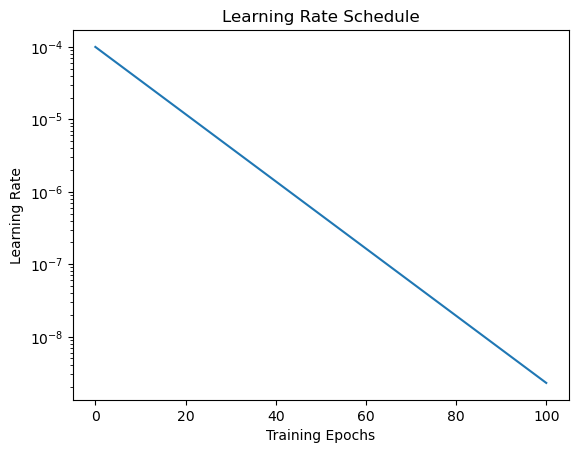

In [7]:
epochs_to_plot = 100

# There are 5000 images in the training set
steps_per_epoch = 5000/batch_size 
steps = int(steps_per_epoch*epochs_to_plot)
epochs = np.linspace(0, epochs_to_plot, len(range(steps)))

plt.figure()
plt.semilogy(epochs, lr_schedule(range(steps)))
plt.xlabel('Training Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()

### Training the Model

In [8]:
history = model.fit(
    train_ds,
    callbacks=[early_stopping],
    epochs=1000,
    validation_data=val_ds
)

Epoch 1/1000


2022-10-26 23:36:19.085811: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-26 23:36:20.435761: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-26 23:36:20.436898: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-10-26 23:36:20.436926: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-10-26 23:36:20.436971: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

744/744 [==============================] - ETA: 0s - loss: 1.7865

2022-10-26 23:47:00.303937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 226 of 1000
2022-10-26 23:47:10.291883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 442 of 1000
2022-10-26 23:47:13.000033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 683s 673ms/step - loss: 1.7865 - val_loss: 1.4755
Epoch 2/1000
744/744 [==============================] - ETA: 0s - loss: 1.4183

2022-10-26 23:52:53.116336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 220 of 1000
2022-10-26 23:53:03.113444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 434 of 1000
2022-10-26 23:53:06.180032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 353s 463ms/step - loss: 1.4183 - val_loss: 1.3902
Epoch 3/1000
744/744 [==============================] - ETA: 0s - loss: 1.3142

2022-10-26 23:58:47.053580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 229 of 1000
2022-10-26 23:58:57.088374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 446 of 1000
2022-10-26 23:58:59.601819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 353s 462ms/step - loss: 1.3142 - val_loss: 1.2793
Epoch 4/1000
744/744 [==============================] - ETA: 0s - loss: 1.2167

2022-10-27 00:04:32.700438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 234 of 1000
2022-10-27 00:04:42.735230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 452 of 1000
2022-10-27 00:04:44.938965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 345s 453ms/step - loss: 1.2167 - val_loss: 1.1820
Epoch 5/1000
744/744 [==============================] - ETA: 0s - loss: 1.1634

2022-10-27 00:10:17.525416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 220 of 1000
2022-10-27 00:10:27.537764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 437 of 1000
2022-10-27 00:10:30.439853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 345s 454ms/step - loss: 1.1634 - val_loss: 1.1552
Epoch 6/1000
744/744 [==============================] - ETA: 0s - loss: 1.1144

2022-10-27 00:16:03.067904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 221 of 1000
2022-10-27 00:16:13.080169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 434 of 1000
2022-10-27 00:16:16.107787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 345s 453ms/step - loss: 1.1144 - val_loss: 1.1553
Epoch 7/1000
744/744 [==============================] - ETA: 0s - loss: 1.0821

2022-10-27 00:21:47.667644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 226 of 1000
2022-10-27 00:21:57.677305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 438 of 1000
2022-10-27 00:22:00.569260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 346s 454ms/step - loss: 1.0821 - val_loss: 1.1025
Epoch 8/1000
744/744 [==============================] - ETA: 0s - loss: 1.0430

2022-10-27 00:27:33.400075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 238 of 1000
2022-10-27 00:27:43.401044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 455 of 1000
2022-10-27 00:27:45.484425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 344s 452ms/step - loss: 1.0430 - val_loss: 1.0734
Epoch 9/1000
744/744 [==============================] - ETA: 0s - loss: 1.0107

2022-10-27 00:33:18.809949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 219 of 1000
2022-10-27 00:33:28.807094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 435 of 1000
2022-10-27 00:33:31.811725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 346s 454ms/step - loss: 1.0107 - val_loss: 1.0540
Epoch 10/1000
744/744 [==============================] - ETA: 0s - loss: 0.9819

2022-10-27 00:39:04.564118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 228 of 1000
2022-10-27 00:39:14.568182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 445 of 1000
2022-10-27 00:39:17.103251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 345s 454ms/step - loss: 0.9819 - val_loss: 1.0229
Epoch 11/1000
744/744 [==============================] - ETA: 0s - loss: 0.9522

2022-10-27 00:44:49.994187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 240 of 1000
2022-10-27 00:44:59.976089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 449 of 1000
2022-10-27 00:45:02.330136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 345s 453ms/step - loss: 0.9522 - val_loss: 1.0014
Epoch 12/1000
744/744 [==============================] - ETA: 0s - loss: 0.9291

2022-10-27 00:50:34.977686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 220 of 1000
2022-10-27 00:50:44.971681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 436 of 1000
2022-10-27 00:50:47.947400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 345s 453ms/step - loss: 0.9291 - val_loss: 1.0116
Epoch 13/1000
744/744 [==============================] - ETA: 0s - loss: 0.9102

2022-10-27 00:56:19.790914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 220 of 1000
2022-10-27 00:56:29.790981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 427 of 1000
2022-10-27 00:56:33.250661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 346s 454ms/step - loss: 0.9102 - val_loss: 0.9932
Epoch 14/1000
744/744 [==============================] - ETA: 0s - loss: 0.8906

2022-10-27 01:02:07.160285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 227 of 1000
2022-10-27 01:02:17.156400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 444 of 1000
2022-10-27 01:02:19.752556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 346s 453ms/step - loss: 0.8906 - val_loss: 0.9936
Epoch 15/1000
744/744 [==============================] - ETA: 0s - loss: 0.8691

2022-10-27 01:07:51.968473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 222 of 1000
2022-10-27 01:08:01.952884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 438 of 1000
2022-10-27 01:08:04.810432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 346s 454ms/step - loss: 0.8691 - val_loss: 0.9813
Epoch 16/1000
744/744 [==============================] - ETA: 0s - loss: 0.8519

2022-10-27 01:13:38.204628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 239 of 1000
2022-10-27 01:13:48.187636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 456 of 1000
2022-10-27 01:13:50.207603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 345s 453ms/step - loss: 0.8519 - val_loss: 0.9807
Epoch 17/1000
744/744 [==============================] - ETA: 0s - loss: 0.8323

2022-10-27 01:19:23.608724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 227 of 1000
2022-10-27 01:19:33.624066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2022-10-27 01:19:36.541096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 346s 454ms/step - loss: 0.8323 - val_loss: 0.9832
Epoch 18/1000
744/744 [==============================] - ETA: 0s - loss: 0.8111

2022-10-27 01:25:16.612672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 214 of 1000
2022-10-27 01:25:26.604691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 429 of 1000
2022-10-27 01:25:29.913562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 353s 462ms/step - loss: 0.8111 - val_loss: 1.0268
Epoch 19/1000
744/744 [==============================] - ETA: 0s - loss: 0.7889

2022-10-27 01:31:08.674464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 241 of 1000
2022-10-27 01:31:18.639940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 455 of 1000
2022-10-27 01:31:20.746070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 351s 461ms/step - loss: 0.7889 - val_loss: 0.9871
Epoch 20/1000
744/744 [==============================] - ETA: 0s - loss: 0.7668

2022-10-27 01:36:56.866231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 227 of 1000
2022-10-27 01:37:06.843283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2022-10-27 01:37:09.657696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 348s 457ms/step - loss: 0.7668 - val_loss: 1.0025
Epoch 21/1000
744/744 [==============================] - ETA: 0s - loss: 0.7426

2022-10-27 01:42:42.485865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 200 of 1000
2022-10-27 01:42:52.487158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 409 of 1000
2022-10-27 01:42:56.761553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 347s 456ms/step - loss: 0.7426 - val_loss: 1.0205
Epoch 22/1000
744/744 [==============================] - ETA: 0s - loss: 0.7202

2022-10-27 01:48:28.952651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 222 of 1000
2022-10-27 01:48:38.943998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 437 of 1000
2022-10-27 01:48:41.846479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 345s 453ms/step - loss: 0.7202 - val_loss: 1.0338
Epoch 23/1000
744/744 [==============================] - ETA: 0s - loss: 0.6960

2022-10-27 01:54:14.126310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 243 of 1000
2022-10-27 01:54:24.128451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 460 of 1000
2022-10-27 01:54:25.979425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 344s 452ms/step - loss: 0.6960 - val_loss: 1.0663
Epoch 24/1000
744/744 [==============================] - ETA: 0s - loss: 0.6717

2022-10-27 01:59:58.790566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 225 of 1000
2022-10-27 02:00:08.784658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 424 of 1000
2022-10-27 02:00:12.337137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 346s 455ms/step - loss: 0.6717 - val_loss: 1.0791
Epoch 25/1000
744/744 [==============================] - ETA: 0s - loss: 0.6506

2022-10-27 02:05:45.591811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 200 of 1000
2022-10-27 02:05:55.573474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 413 of 1000
2022-10-27 02:05:59.603623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 347s 455ms/step - loss: 0.6506 - val_loss: 1.1001
Epoch 26/1000
744/744 [==============================] - ETA: 0s - loss: 0.6286

2022-10-27 02:11:32.146108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 222 of 1000
2022-10-27 02:11:42.152911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 437 of 1000
2022-10-27 02:11:45.083403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 347s 456ms/step - loss: 0.6286 - val_loss: 1.1056


### Plotting Model Training

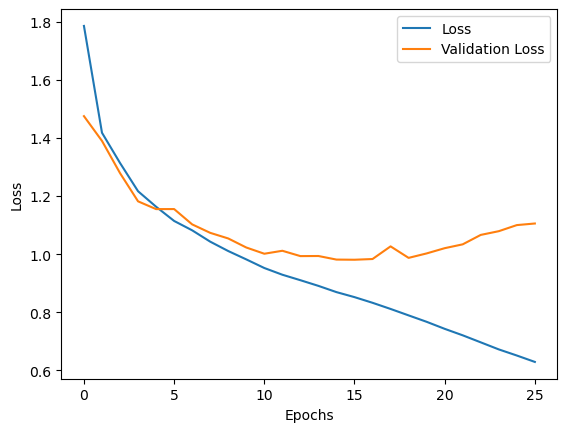

In [9]:
plot_model_training(history)

### Visualizing the Model's Predictions

2022-10-27 11:31:17.222725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2022-10-27 11:31:27.192135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 440 of 1000
2022-10-27 11:31:29.951146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


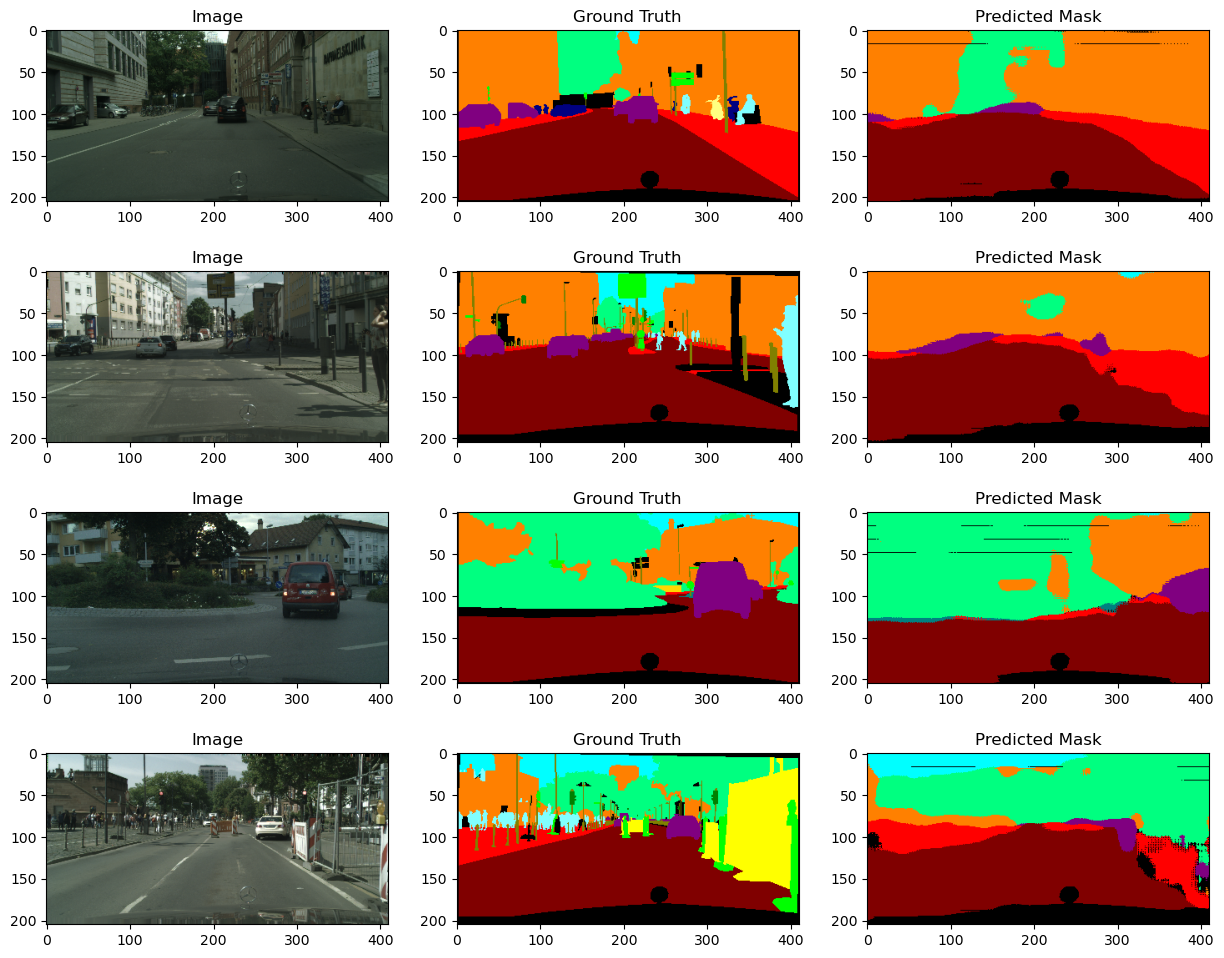

In [8]:
# Optionally load the model, get predictions and show them
use_saved_model = True

if use_saved_model:
    model = tf.keras.models.load_model('U-Net')

examples_to_show = 4 # can't be greater than the batch size
show_examples(model, val_ds, examples_to_show)

The results are roughly accurate, but lack resolution and miss features not part of the main classes, like people. The model mostly picks up the large structure of the image, but misses the finer details and sometimes messes up the location of the smaller classes (like cars). We also find that the unweighted model does better than the weighted model.

### Saving the Model

In [12]:
model.save('unet')

INFO:tensorflow:Assets written to: unet/assets


INFO:tensorflow:Assets written to: unet/assets


## Residual-Skip U-Net

We now train the same U-Net but with the skip-connections being added to the feature maps instead of concatenated with them

In [14]:
inputs = tf.keras.Input(shape=(205, 410, 3), name='image')
# Contracting path
x = tf.keras.layers.Conv2D(128, 3, activation='relu')(inputs)
step1_output = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)

x = tf.keras.layers.MaxPool2D(strides=(2, 2))(step1_output)

x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
step2_output = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)

x = tf.keras.layers.MaxPool2D(strides=(2, 2))(step2_output)

x = tf.keras.layers.Conv2D(512, 3, activation='relu')(x)
step3_output = tf.keras.layers.Conv2D(512, 3, activation='relu')(x)

x = tf.keras.layers.MaxPool2D(strides=(2, 2))(step3_output)

# Expanding path
x = tf.keras.layers.Conv2D(1024, 3, activation='relu')(x)
x = tf.keras.layers.Conv2D(1024, 3, activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(
    512, 2,
    activation='relu',
    strides=(2, 2)
)(x)

step3_output = tf.keras.layers.Cropping2D(((4, 4), (4, 5)))(step3_output)
x = tf.keras.layers.add([x, step3_output])

x = tf.keras.layers.Conv2D(512, 3, activation='relu')(x)
x = tf.keras.layers.Conv2D(512, 3, activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(
    256, 2,
    activation='relu',
    strides=(2, 2)
)(x)

step2_output = tf.keras.layers.Cropping2D(((16, 16), (17, 18)))(step2_output)
x = tf.keras.layers.add([x, step2_output])

x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(
    128, 2,
    activation='relu',
    strides=(2, 2)
)(x)

step1_output = tf.keras.layers.Cropping2D(((40, 41), (43, 43)))(step1_output)
x = tf.keras.layers.add([x, step1_output])

x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)

x = tf.keras.layers.Conv2DTranspose(
    64, 2,
    activation='relu',
    strides=(2, 2)
)(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)

x = tf.keras.layers.Cropping2D(((11, 12), (109, 109)))(x)

x = tf.keras.layers.Conv2D(20, 1, activation='relu')(x)
# We have 20 segmentation classes in total

outputs = tf.keras.layers.Softmax()(x)

model = tf.keras.Model(inputs, outputs, name='Residual_Skip_U-Net')
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 205, 410, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 203, 408, 12  3584        ['image[0][0]']                  
                                8)                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 201, 406, 12  147584      ['conv2d_17[0][0]']              
                                8)                                                            

### Defining the Training

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    mode='min',
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_rate=0.95,
    decay_steps=600
    # There are 744 steps per epoch with a batch size of 4
    # May or may not be worth it to make this stepwise so its
    # constant over each batch
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    loss=loss,
    optimizer=optimizer,
    weighted_metrics=[]
)

### Plotting the Learning Rate

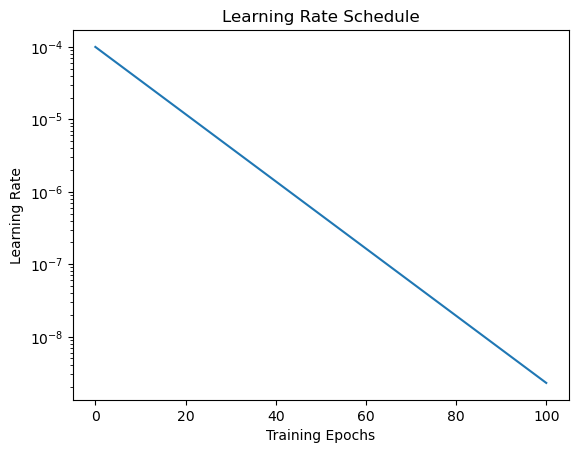

In [16]:
epochs_to_plot = 100

# There are 5000 images in the training set
steps_per_epoch = 5000/batch_size 
steps = int(steps_per_epoch*epochs_to_plot)
epochs = np.linspace(0, epochs_to_plot, len(range(steps)))

plt.figure()
plt.semilogy(epochs, lr_schedule(range(steps)))
plt.xlabel('Training Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()

### Training the Model

In [17]:
history = model.fit(
    train_ds,
    callbacks=[early_stopping],
    epochs=1000,
    validation_data=val_ds
)

Epoch 1/1000


2022-10-27 11:45:48.906372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 199 of 1000
2022-10-27 11:45:58.902687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 417 of 1000
2022-10-27 11:46:08.904957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 636 of 1000
2022-10-27 11:46:18.866663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 854 of 1000
2022-10-27 11:46:25.586541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 1.8386

2022-10-27 11:55:38.426542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 231 of 1000
2022-10-27 11:55:48.448763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 447 of 1000
2022-10-27 11:55:50.901553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 628s 592ms/step - loss: 1.8386 - val_loss: 1.5510
Epoch 2/1000


2022-10-27 11:56:15.830323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 210 of 1000
2022-10-27 11:56:25.842060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 419 of 1000
2022-10-27 11:56:35.844530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 617 of 1000
2022-10-27 11:56:45.854572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 816 of 1000
2022-10-27 11:56:55.142523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 1.4895

2022-10-27 12:01:35.482675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 218 of 1000
2022-10-27 12:01:45.454814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 428 of 1000
2022-10-27 12:01:48.801945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 358s 414ms/step - loss: 1.4895 - val_loss: 1.4299
Epoch 3/1000


2022-10-27 12:02:13.725749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 188 of 1000
2022-10-27 12:02:23.727564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 400 of 1000
2022-10-27 12:02:33.751884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 608 of 1000
2022-10-27 12:02:43.729959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 810 of 1000
2022-10-27 12:02:52.648420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 1.3748

2022-10-27 12:07:32.741097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 236 of 1000
2022-10-27 12:07:42.779084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 452 of 1000
2022-10-27 12:07:44.994959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 356s 413ms/step - loss: 1.3748 - val_loss: 1.3580
Epoch 4/1000


2022-10-27 12:08:09.911838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 207 of 1000
2022-10-27 12:08:19.920656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 419 of 1000
2022-10-27 12:08:29.882382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 628 of 1000
2022-10-27 12:08:39.885561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 835 of 1000
2022-10-27 12:08:48.061921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 1.2949

2022-10-27 12:13:28.526561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 207 of 1000
2022-10-27 12:13:38.515903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 421 of 1000
2022-10-27 12:13:42.193264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 358s 416ms/step - loss: 1.2949 - val_loss: 1.2610
Epoch 5/1000


2022-10-27 12:14:07.795263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 206 of 1000
2022-10-27 12:14:17.831168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 417 of 1000
2022-10-27 12:14:27.795516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 625 of 1000
2022-10-27 12:14:37.819916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 837 of 1000
2022-10-27 12:14:45.644710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 1.2412

2022-10-27 12:19:26.335671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 219 of 1000
2022-10-27 12:19:36.314396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 432 of 1000
2022-10-27 12:19:39.487402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 357s 416ms/step - loss: 1.2412 - val_loss: 1.2243
Epoch 6/1000


2022-10-27 12:20:05.111661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 207 of 1000
2022-10-27 12:20:15.107653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 411 of 1000
2022-10-27 12:20:25.115292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 626 of 1000
2022-10-27 12:20:35.096235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 840 of 1000
2022-10-27 12:20:42.546909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 1.1964

2022-10-27 12:25:22.878236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 221 of 1000
2022-10-27 12:25:32.893233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 428 of 1000
2022-10-27 12:25:36.404461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 356s 415ms/step - loss: 1.1964 - val_loss: 1.2040
Epoch 7/1000


2022-10-27 12:26:01.583179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 203 of 1000
2022-10-27 12:26:11.592830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 418 of 1000
2022-10-27 12:26:21.551920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 633 of 1000
2022-10-27 12:26:31.594234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 849 of 1000
2022-10-27 12:26:38.581260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 1.1113

2022-10-27 12:31:18.891074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2022-10-27 12:31:28.905309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2022-10-27 12:31:31.738572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 355s 414ms/step - loss: 1.1113 - val_loss: 1.0979
Epoch 8/1000


2022-10-27 12:31:56.912777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 203 of 1000
2022-10-27 12:32:06.911395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 420 of 1000
2022-10-27 12:32:16.937878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 638 of 1000
2022-10-27 12:32:26.922072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 855 of 1000
2022-10-27 12:32:33.629997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 1.0408

2022-10-27 12:37:08.873996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 232 of 1000
2022-10-27 12:37:18.853416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 447 of 1000
2022-10-27 12:37:21.296701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 349s 406ms/step - loss: 1.0408 - val_loss: 1.0641
Epoch 9/1000


2022-10-27 12:37:46.102187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 209 of 1000
2022-10-27 12:37:56.094736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 427 of 1000
2022-10-27 12:38:06.088961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 643 of 1000
2022-10-27 12:38:16.103242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 859 of 1000
2022-10-27 12:38:22.642927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 1.0074

2022-10-27 12:42:58.157704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 209 of 1000
2022-10-27 12:43:08.134197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 410 of 1000
2022-10-27 12:43:12.285747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 351s 409ms/step - loss: 1.0074 - val_loss: 1.0513
Epoch 10/1000


2022-10-27 12:43:37.051959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 198 of 1000
2022-10-27 12:43:47.050854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 404 of 1000
2022-10-27 12:43:57.051739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 617 of 1000
2022-10-27 12:44:07.056960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 831 of 1000
2022-10-27 12:44:14.860916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.9766

2022-10-27 12:48:50.013470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 228 of 1000
2022-10-27 12:49:00.000928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 445 of 1000
2022-10-27 12:49:02.537147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 350s 406ms/step - loss: 0.9766 - val_loss: 1.0264
Epoch 11/1000


2022-10-27 12:49:27.311602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 206 of 1000
2022-10-27 12:49:37.315230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 424 of 1000
2022-10-27 12:49:47.329687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 641 of 1000
2022-10-27 12:49:57.309426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 858 of 1000
2022-10-27 12:50:03.861291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.9548

2022-10-27 12:54:39.610997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-10-27 12:54:49.580081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 440 of 1000
2022-10-27 12:54:52.344189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 350s 407ms/step - loss: 0.9548 - val_loss: 1.0185
Epoch 12/1000


2022-10-27 12:55:17.112295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 210 of 1000
2022-10-27 12:55:27.146017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 428 of 1000
2022-10-27 12:55:37.150994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 646 of 1000
2022-10-27 12:55:47.119204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 863 of 1000
2022-10-27 12:55:53.450906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.9340

2022-10-27 13:00:29.107006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 235 of 1000
2022-10-27 13:00:39.098724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 452 of 1000
2022-10-27 13:00:41.318899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 349s 406ms/step - loss: 0.9340 - val_loss: 1.0203
Epoch 13/1000


2022-10-27 13:01:06.063509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 210 of 1000
2022-10-27 13:01:16.096220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 424 of 1000
2022-10-27 13:01:26.080874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 636 of 1000
2022-10-27 13:01:36.078728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 846 of 1000
2022-10-27 13:01:43.251318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.9132

2022-10-27 13:06:18.665678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 234 of 1000
2022-10-27 13:06:28.650887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 450 of 1000
2022-10-27 13:06:30.962256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 350s 406ms/step - loss: 0.9132 - val_loss: 1.0197
Epoch 14/1000


2022-10-27 13:06:55.677239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 207 of 1000
2022-10-27 13:07:05.679945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 425 of 1000
2022-10-27 13:07:15.640962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 642 of 1000
2022-10-27 13:07:25.662604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 860 of 1000
2022-10-27 13:07:32.122125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.8945

2022-10-27 13:12:07.758216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2022-10-27 13:12:17.751120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 440 of 1000
2022-10-27 13:12:20.523543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 350s 407ms/step - loss: 0.8945 - val_loss: 1.0060
Epoch 15/1000


2022-10-27 13:12:45.338162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 210 of 1000
2022-10-27 13:12:55.337690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 427 of 1000
2022-10-27 13:13:05.326862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 645 of 1000
2022-10-27 13:13:15.299799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 862 of 1000
2022-10-27 13:13:21.676537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.8720

2022-10-27 13:17:57.040261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2022-10-27 13:18:07.050041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 440 of 1000
2022-10-27 13:18:09.825290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 349s 407ms/step - loss: 0.8720 - val_loss: 1.0113
Epoch 16/1000


2022-10-27 13:18:34.631651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 210 of 1000
2022-10-27 13:18:44.646743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 428 of 1000
2022-10-27 13:18:54.609614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 645 of 1000
2022-10-27 13:19:04.638638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 861 of 1000
2022-10-27 13:19:11.241103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.8493

2022-10-27 13:23:46.753221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2022-10-27 13:23:56.740368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2022-10-27 13:23:59.552907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 350s 407ms/step - loss: 0.8493 - val_loss: 1.0248
Epoch 17/1000


2022-10-27 13:24:24.294378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 207 of 1000
2022-10-27 13:24:34.309438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 425 of 1000
2022-10-27 13:24:44.296350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 642 of 1000
2022-10-27 13:24:54.327667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 860 of 1000
2022-10-27 13:25:00.814100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.8200

2022-10-27 13:29:36.085586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 236 of 1000
2022-10-27 13:29:46.082562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 452 of 1000
2022-10-27 13:29:48.284307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 349s 406ms/step - loss: 0.8200 - val_loss: 1.0111
Epoch 18/1000


2022-10-27 13:30:13.009474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 215 of 1000
2022-10-27 13:30:22.999059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 432 of 1000
2022-10-27 13:30:33.015097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 650 of 1000
2022-10-27 13:30:43.016219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 867 of 1000
2022-10-27 13:30:49.168252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.7912

2022-10-27 13:35:24.768433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 234 of 1000
2022-10-27 13:35:34.811622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 446 of 1000
2022-10-27 13:35:37.340125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 349s 407ms/step - loss: 0.7912 - val_loss: 1.0262
Epoch 19/1000


2022-10-27 13:36:02.078701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 205 of 1000
2022-10-27 13:36:12.139203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 416 of 1000
2022-10-27 13:36:22.079025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 618 of 1000
2022-10-27 13:36:32.074426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 829 of 1000
2022-10-27 13:36:39.966310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.7677

2022-10-27 13:41:15.455516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 222 of 1000
2022-10-27 13:41:25.451611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2022-10-27 13:41:28.258781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 351s 407ms/step - loss: 0.7677 - val_loss: 1.0270
Epoch 20/1000


2022-10-27 13:41:53.038893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 206 of 1000
2022-10-27 13:42:03.040989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 423 of 1000
2022-10-27 13:42:13.047458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 641 of 1000
2022-10-27 13:42:23.029761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 858 of 1000
2022-10-27 13:42:29.588848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.7405

2022-10-27 13:47:05.112862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 235 of 1000
2022-10-27 13:47:15.083949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 452 of 1000
2022-10-27 13:47:17.310206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 349s 406ms/step - loss: 0.7405 - val_loss: 1.0511
Epoch 21/1000


2022-10-27 13:47:42.102367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 217 of 1000
2022-10-27 13:47:52.071683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 433 of 1000
2022-10-27 13:48:02.072687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 651 of 1000
2022-10-27 13:48:12.077433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 863 of 1000
2022-10-27 13:48:18.402673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.7147

2022-10-27 13:52:53.982311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-10-27 13:53:03.954840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 440 of 1000
2022-10-27 13:53:06.726386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 349s 407ms/step - loss: 0.7147 - val_loss: 1.0606
Epoch 22/1000


2022-10-27 13:53:31.449748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 208 of 1000
2022-10-27 13:53:41.470648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 423 of 1000
2022-10-27 13:53:51.457044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 638 of 1000
2022-10-27 13:54:01.450910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 854 of 1000
2022-10-27 13:54:08.193723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.6905

2022-10-27 13:58:44.139483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2022-10-27 13:58:54.153070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 440 of 1000
2022-10-27 13:58:56.912331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 350s 408ms/step - loss: 0.6905 - val_loss: 1.0887
Epoch 23/1000


2022-10-27 13:59:21.660732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 210 of 1000
2022-10-27 13:59:31.668826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 427 of 1000
2022-10-27 13:59:41.645921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 645 of 1000
2022-10-27 13:59:51.660121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 862 of 1000
2022-10-27 13:59:58.017796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.6670

2022-10-27 14:04:35.501315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 222 of 1000
2022-10-27 14:04:45.495137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 436 of 1000
2022-10-27 14:04:48.486510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 352s 411ms/step - loss: 0.6670 - val_loss: 1.0925
Epoch 24/1000


2022-10-27 14:05:13.707762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 207 of 1000
2022-10-27 14:05:23.708474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 422 of 1000
2022-10-27 14:05:33.695746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 638 of 1000
2022-10-27 14:05:43.668043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 853 of 1000
2022-10-27 14:05:50.530738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.6448

2022-10-27 14:10:31.492677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 231 of 1000
2022-10-27 14:10:41.514312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 446 of 1000
2022-10-27 14:10:44.046027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 356s 415ms/step - loss: 0.6448 - val_loss: 1.1166


### Plotting Model Training

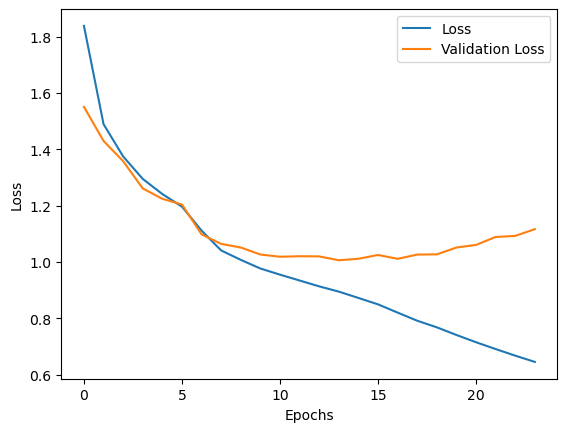

In [18]:
plot_model_training(history)

### Visualizing the Model's Predictions

2022-10-27 14:11:10.901590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 231 of 1000
2022-10-27 14:11:20.923798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 446 of 1000
2022-10-27 14:11:23.430766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


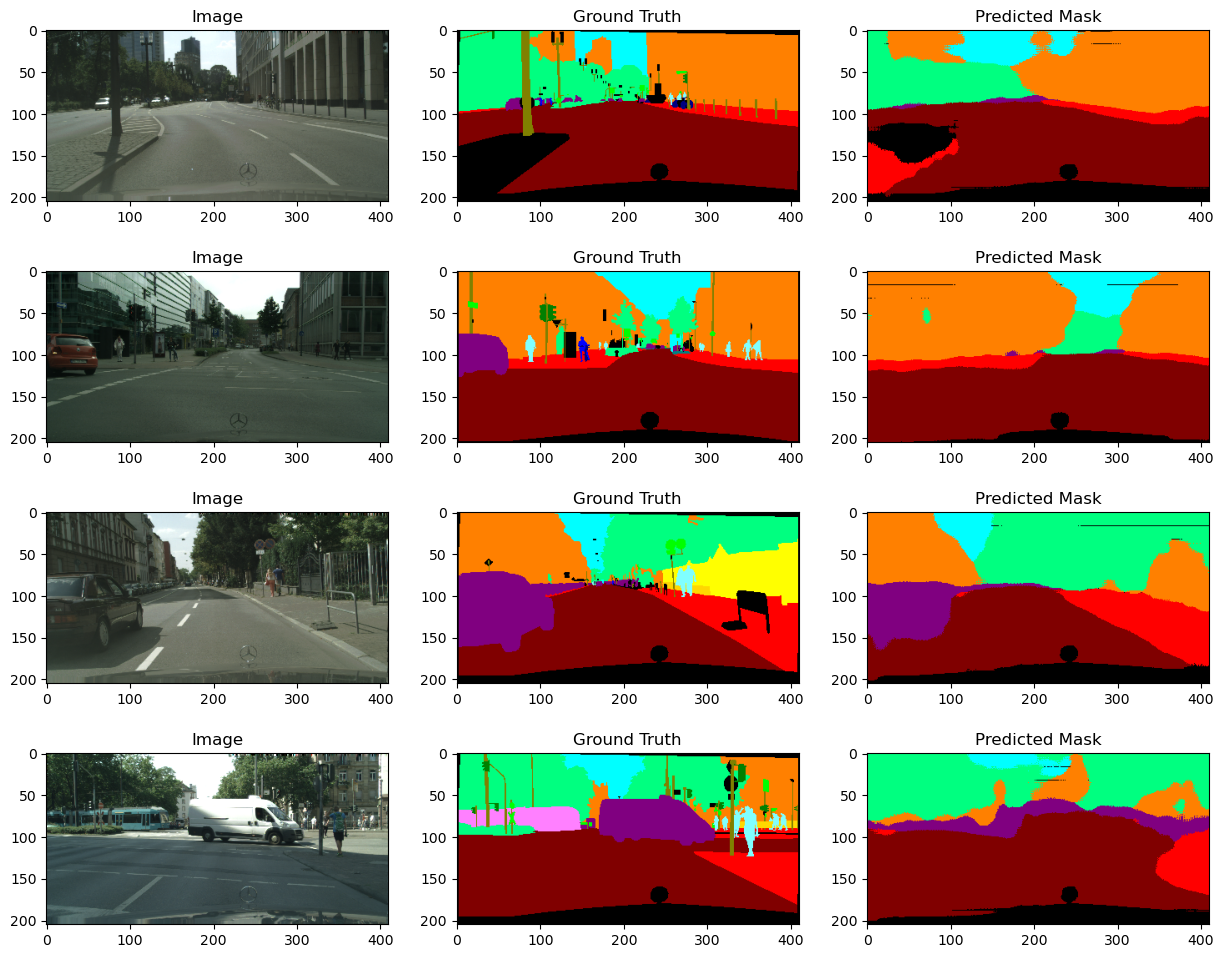

In [19]:
# Optionally load the model, get predictions and show them

use_saved_model = False

if use_saved_model:
    model = tf.keras.models.load_model('Residual Skip U-Net')

examples_to_show = 4 # can't be greater than the batch size
show_examples(model, val_ds, examples_to_show)

These results visually seem very similar to the original results and the loss values achieved are essentially unchanged from the original model, so it doesn't seem like the change makes very much difference

### Saving the Model

In [ ]:
model.save('Residual-Skip U-Net')

## Residual U-Net

We now try adding batch normalization and residual connections to the U-Net to see if that improves the results. These residual connections won't get the full benefit of being residual connections since our architecture involves tensors of various shape so it can't be fully residual. Nonetheless we investigate if they improve performance at all.

In [65]:
class Upsampling(tf.keras.layers.Layer):
    def __init__(self, filters, cropping):
        super().__init__()
        self.conv_transpose = tf.keras.layers.Conv2DTranspose(
            filters, 2,
            activation='relu', strides=(2, 2)
        )
        self.cropping = tf.keras.layers.Cropping2D(cropping)
        
    def call(self, inputs, downsampling_output):
        x = self.conv_transpose(inputs)
        y = self.cropping(downsampling_output)
        x = tf.keras.layers.concatenate([x, y])
        return x


class ResidualConvolution(tf.keras.layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.layer1 = tf.keras.layers.Conv2D(
            filters, 3,
            activation='relu',
            padding='same'
        )
        self.normalization1 = tf.keras.layers.BatchNormalization()
        self.layer2 = tf.keras.layers.Conv2D(
            filters, 3,
            activation='relu',
            padding='same'
        )
        self.normalization2 = tf.keras.layers.BatchNormalization()
        
    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.normalization1(x)
        y = self.layer2(x)
        y = self.normalization2(y)
        x = tf.keras.layers.add([x, y])
        return x


# Contracting path
inputs = tf.keras.Input(shape=(205, 410, 3), name='image')
step1_output = ResidualConvolution(128)(inputs)
x = tf.keras.layers.MaxPool2D(strides=(2, 2))(step1_output)
step2_output = ResidualConvolution(256)(x)
x = tf.keras.layers.MaxPool2D()(step2_output)
step3_output = ResidualConvolution(512)(x)
x = tf.keras.layers.MaxPool2D()(step3_output)
# Expanding path
x = ResidualConvolution(1024)(x)
x = Upsampling(512, ((0, 1), (0, 0)))(x, step3_output)
x = ResidualConvolution(512)(x)
x = Upsampling(256, ((1, 1), (0, 1)))(x, step2_output)
x = ResidualConvolution(256)(x)
x = Upsampling(128, ((2, 3), (1, 1)))(x, step1_output)
x = ResidualConvolution(128)(x)

x = tf.keras.layers.Conv2D(20, 1, activation='relu')(x)
# We have 20 segmentation classes in total

outputs = tf.keras.layers.Softmax()(x)

model = tf.keras.Model(inputs, outputs, name='Residual_U-Net')
model.summary()

Model: "Residual_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 205, 410, 3  0           []                               
                                )]                                                                
                                                                                                  
 residual_convolution_56 (Resid  (None, 205, 410, 12  152192     ['image[0][0]']                  
 ualConvolution)                8)                                                                
                                                                                                  
 max_pooling2d_102 (MaxPooling2  (None, 102, 205, 12  0          ['residual_convolution_56[0][0]']
 D)                             8)                                                   

### Reloading the Dataset

For this dataset, we have to crop the images slightly so we must reload the dataset

In [5]:
train_ds, val_ds = tfds.load('cityscapes', split=['train', 'validation'])
label_shape = (200, 408)
train_ds = process_train_ds(train_ds, label_shape)
val_ds = process_train_ds(val_ds, label_shape)

### Defining the Training

In [67]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    mode='min',
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_rate=0.95,
    decay_steps=600
    # There are 744 steps per epoch with a batch size of 4
    # May or may not be worth it to make this stepwise so its
    # constant over each batch
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    loss=loss,
    optimizer=optimizer,
    weighted_metrics=[]
)

### Plotting the Learning Rate

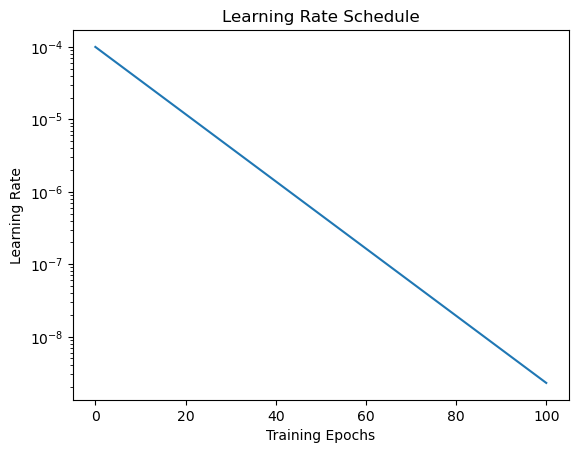

In [68]:
epochs_to_plot = 100

# There are 5000 images in the training set
steps_per_epoch = 5000/batch_size 
steps = int(steps_per_epoch*epochs_to_plot)
epochs = np.linspace(0, epochs_to_plot, len(range(steps)))

plt.figure()
plt.semilogy(epochs, lr_schedule(range(steps)))
plt.xlabel('Training Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()

### Training the Model

In [69]:
history = model.fit(
    train_ds,
    callbacks=[early_stopping],
    epochs=1000,
    validation_data=val_ds
)

Epoch 1/1000


2022-10-30 17:04:02.045725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 162 of 1000
2022-10-30 17:04:12.015386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 341 of 1000
2022-10-30 17:04:22.031966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 523 of 1000
2022-10-30 17:04:32.026715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 734 of 1000
2022-10-30 17:04:42.046722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 929 of 1000
2022-10-30 17:04:45.513984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.9135

2022-10-30 17:20:28.759125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 213 of 1000
2022-10-30 17:20:38.760922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 426 of 1000
2022-10-30 17:20:42.221271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 1038s 1s/step - loss: 0.9135 - val_loss: 0.7738
Epoch 2/1000


2022-10-30 17:21:17.674403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 182 of 1000
2022-10-30 17:21:27.690409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 392 of 1000
2022-10-30 17:21:37.665676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 601 of 1000
2022-10-30 17:21:47.665120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 811 of 1000
2022-10-30 17:21:56.553221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.6211

2022-10-30 17:29:47.164358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 204 of 1000
2022-10-30 17:29:57.162744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 419 of 1000
2022-10-30 17:30:00.928730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 558s 684ms/step - loss: 0.6211 - val_loss: 0.6454
Epoch 3/1000


2022-10-30 17:30:35.314123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 195 of 1000
2022-10-30 17:30:45.288618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 411 of 1000
2022-10-30 17:30:55.323674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 626 of 1000
2022-10-30 17:31:05.306863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 827 of 1000
2022-10-30 17:31:13.553620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.5276

2022-10-30 17:39:03.406418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 212 of 1000
2022-10-30 17:39:13.366526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 416 of 1000
2022-10-30 17:39:17.355261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 557s 683ms/step - loss: 0.5276 - val_loss: 0.5506
Epoch 4/1000


2022-10-30 17:39:52.180264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 208 of 1000
2022-10-30 17:40:02.155379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 417 of 1000
2022-10-30 17:40:12.182590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 622 of 1000
2022-10-30 17:40:22.153662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 831 of 1000
2022-10-30 17:40:30.370736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.4727

2022-10-30 17:48:20.851440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 216 of 1000
2022-10-30 17:48:30.868863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 424 of 1000
2022-10-30 17:48:34.502862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 557s 684ms/step - loss: 0.4727 - val_loss: 0.5140
Epoch 5/1000


2022-10-30 17:49:09.365181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 198 of 1000
2022-10-30 17:49:19.376253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 405 of 1000
2022-10-30 17:49:29.363030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 610 of 1000
2022-10-30 17:49:39.367154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 820 of 1000
2022-10-30 17:49:48.323621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.4269

2022-10-30 17:57:32.680055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 222 of 1000
2022-10-30 17:57:42.703594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 435 of 1000
2022-10-30 17:57:45.810238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 551s 675ms/step - loss: 0.4269 - val_loss: 0.4624
Epoch 6/1000


2022-10-30 17:58:20.935625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 192 of 1000
2022-10-30 17:58:30.934884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 398 of 1000
2022-10-30 17:58:40.940777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 610 of 1000
2022-10-30 17:58:50.946440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 801 of 1000
2022-10-30 17:59:00.289122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.3915

2022-10-30 18:06:51.614725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 220 of 1000
2022-10-30 18:07:01.606297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 427 of 1000
2022-10-30 18:07:05.167999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 559s 685ms/step - loss: 0.3915 - val_loss: 0.4685
Epoch 7/1000


2022-10-30 18:07:40.327446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2022-10-30 18:07:50.317730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 386 of 1000
2022-10-30 18:08:00.334753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 595 of 1000
2022-10-30 18:08:10.307540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 803 of 1000
2022-10-30 18:08:19.772057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.3588

2022-10-30 18:16:09.867824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 222 of 1000
2022-10-30 18:16:19.836762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 425 of 1000
2022-10-30 18:16:23.374747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 558s 683ms/step - loss: 0.3588 - val_loss: 0.4740
Epoch 8/1000


2022-10-30 18:16:58.377884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 207 of 1000
2022-10-30 18:17:08.335540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 421 of 1000
2022-10-30 18:17:18.363388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 636 of 1000
2022-10-30 18:17:28.375332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 839 of 1000
2022-10-30 18:17:36.777765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.3266

2022-10-30 18:25:26.769229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 218 of 1000
2022-10-30 18:25:36.755706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 430 of 1000
2022-10-30 18:25:40.054030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 557s 683ms/step - loss: 0.3266 - val_loss: 0.5135
Epoch 9/1000


2022-10-30 18:26:15.020873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 205 of 1000
2022-10-30 18:26:25.023349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 419 of 1000
2022-10-30 18:26:34.979967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 627 of 1000
2022-10-30 18:26:45.023542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 839 of 1000
2022-10-30 18:26:52.571591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.2945

2022-10-30 18:34:43.408870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 210 of 1000
2022-10-30 18:34:53.375204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 423 of 1000
2022-10-30 18:34:57.209382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 557s 685ms/step - loss: 0.2945 - val_loss: 0.4560
Epoch 10/1000


2022-10-30 18:35:32.209617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 185 of 1000
2022-10-30 18:35:42.241817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 397 of 1000
2022-10-30 18:35:52.249119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 602 of 1000
2022-10-30 18:36:02.227891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 811 of 1000
2022-10-30 18:36:11.078196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.2693

2022-10-30 18:43:56.404460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2022-10-30 18:44:06.411229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2022-10-30 18:44:09.231151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 551s 675ms/step - loss: 0.2693 - val_loss: 0.4906
Epoch 11/1000


2022-10-30 18:44:43.551759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 204 of 1000
2022-10-30 18:44:53.575022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 421 of 1000
2022-10-30 18:45:03.570243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 637 of 1000
2022-10-30 18:45:13.540668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 853 of 1000
2022-10-30 18:45:20.495950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.2376

2022-10-30 18:53:02.305425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 219 of 1000
2022-10-30 18:53:12.274705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 413 of 1000
2022-10-30 18:53:16.986787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 548s 673ms/step - loss: 0.2376 - val_loss: 0.4603
Epoch 12/1000


2022-10-30 18:53:51.319545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 208 of 1000
2022-10-30 18:54:01.309762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 424 of 1000
2022-10-30 18:54:11.319204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 641 of 1000
2022-10-30 18:54:21.323919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 855 of 1000
2022-10-30 18:54:28.056122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.2119

2022-10-30 19:02:09.478946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-10-30 19:02:19.479816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 440 of 1000
2022-10-30 19:02:22.269558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 545s 670ms/step - loss: 0.2119 - val_loss: 0.4787
Epoch 13/1000


2022-10-30 19:02:56.628174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 211 of 1000
2022-10-30 19:03:06.642630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 421 of 1000
2022-10-30 19:03:16.625847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 638 of 1000
2022-10-30 19:03:26.623420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 855 of 1000
2022-10-30 19:03:33.357396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.1896

2022-10-30 19:11:15.104360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 229 of 1000
2022-10-30 19:11:25.080431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 444 of 1000
2022-10-30 19:11:27.675699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 545s 670ms/step - loss: 0.1896 - val_loss: 0.4914
Epoch 14/1000


2022-10-30 19:12:02.033757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 203 of 1000
2022-10-30 19:12:12.040378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 418 of 1000
2022-10-30 19:12:22.023745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 635 of 1000
2022-10-30 19:12:32.028847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 852 of 1000
2022-10-30 19:12:38.931289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.1707

2022-10-30 19:20:20.686367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-10-30 19:20:30.674100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 440 of 1000
2022-10-30 19:20:33.599775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 546s 670ms/step - loss: 0.1707 - val_loss: 0.5251
Epoch 15/1000


2022-10-30 19:21:07.928945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 216 of 1000
2022-10-30 19:21:17.946046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 433 of 1000
2022-10-30 19:21:27.914488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 649 of 1000
2022-10-30 19:21:37.942023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 866 of 1000
2022-10-30 19:21:44.162161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.1541

2022-10-30 19:29:25.717497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2022-10-30 19:29:35.751295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 432 of 1000
2022-10-30 19:29:39.795740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 546s 672ms/step - loss: 0.1541 - val_loss: 0.5072
Epoch 16/1000


2022-10-30 19:30:14.120031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 207 of 1000
2022-10-30 19:30:24.138221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 424 of 1000
2022-10-30 19:30:34.130126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 639 of 1000
2022-10-30 19:30:44.125621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 855 of 1000
2022-10-30 19:30:50.855184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.1407

2022-10-30 19:38:32.450865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2022-10-30 19:38:42.466449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2022-10-30 19:38:45.311811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 545s 670ms/step - loss: 0.1407 - val_loss: 0.5236
Epoch 17/1000


2022-10-30 19:39:19.673772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 187 of 1000
2022-10-30 19:39:29.683318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 396 of 1000
2022-10-30 19:39:39.696534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 605 of 1000
2022-10-30 19:39:49.669092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 822 of 1000
2022-10-30 19:39:57.887374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.1299

2022-10-30 19:47:39.444329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 221 of 1000
2022-10-30 19:47:49.408085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 436 of 1000
2022-10-30 19:47:52.377871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 547s 670ms/step - loss: 0.1299 - val_loss: 0.5371
Epoch 18/1000


2022-10-30 19:48:26.746844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 228 of 1000
2022-10-30 19:48:36.735509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 443 of 1000
2022-10-30 19:48:46.741056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 660 of 1000
2022-10-30 19:48:56.736905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 877 of 1000
2022-10-30 19:49:02.415201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.1206

2022-10-30 19:56:44.278138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 225 of 1000
2022-10-30 19:56:54.239826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 441 of 1000
2022-10-30 19:56:57.000655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 545s 670ms/step - loss: 0.1206 - val_loss: 0.5437
Epoch 19/1000


2022-10-30 19:57:31.314871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 211 of 1000
2022-10-30 19:57:41.310121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 418 of 1000
2022-10-30 19:57:51.328407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 628 of 1000
2022-10-30 19:58:01.328664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 845 of 1000
2022-10-30 19:58:08.506668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - ETA: 0s - loss: 0.1151

2022-10-30 20:05:51.869429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 232 of 1000
2022-10-30 20:06:01.870747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 440 of 1000
2022-10-30 20:06:04.954932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 550s 675ms/step - loss: 0.1151 - val_loss: 0.5962


### Plotting the Model Training

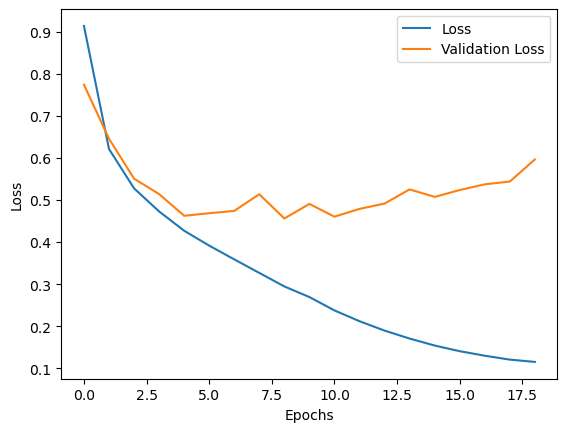

In [70]:
plot_model_training(history)

### Visualizing the Model's Predictions

2022-11-01 14:53:35.712256: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-01 14:53:37.084292: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-01 14:53:37.085588: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-11-01 14:53:37.085619: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-11-01 14:53:37.085665: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

1/1 [==============================] - 0s 22ms/step


2022-11-01 14:53:42.634420: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 21ms/step


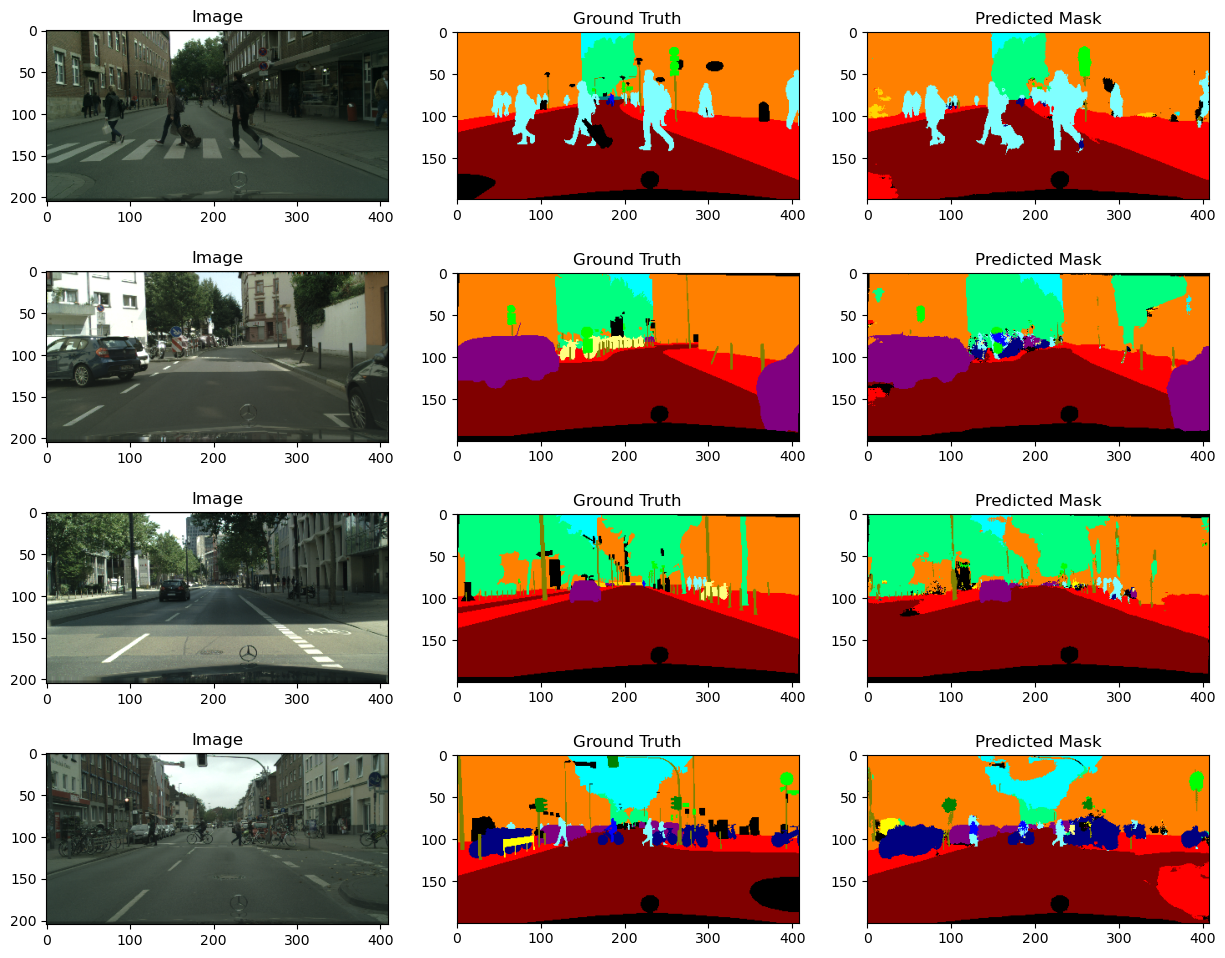

In [13]:
# Optionally load the model, get predictions and show them
use_saved_model = True

if use_saved_model:
    model = tf.keras.models.load_model('Residual U-Net')

examples_to_show = 4 # can't be greater than the batch size
show_examples(model, val_ds, examples_to_show)

The model is now significantly better! Even making misclassifications that I would agree with, such as the classification of the top right chunk of 'vegetation' in the second image that was left as 'building' in the ground truth label or the chunk of what looks like me to be a sidewalk classified as 'unlabelled' after my class modifications on the right of the bottom image. The model is also now classifying cars and people very accurately! Batch normalization and the residual connections made a huge difference for this project! I suspect batch normalization is the greater part of the difference but tough to say without further testing. I also expect that with further tuning of the learning rate and other hyperparameters, even better performance could be achieved.

### Saving the Model

In [73]:
model.save('Residual U-Net')

INFO:tensorflow:Assets written to: Residual U-Net/assets


INFO:tensorflow:Assets written to: Residual U-Net/assets


## ViT

Here we train a vision transformer (ViT) using a dense prediction adapter following this <a href="https://arxiv.org/abs/2205.08534">paper</a> (State of the art at the time of writing) and compare results to the U-Nets above. We process the dataset to present the image as a sequence of patches, as mentioned in the original ViT <a href="https://arxiv.org/abs/2010.11929v2">paper</a>. For our relatively small image size, we use patches of size 5x5 as opposed to the original ViT paper's 16x16 patches.

### Reloading the Dataset

In [4]:
label_shape = (205, 410)
train_ds, val_ds = tfds.load('cityscapes', split=['train', 'validation'])
train_ds = process_train_ds(train_ds, label_shape)
val_ds = process_train_ds(val_ds, label_shape)

### Defining the Model

In [5]:
attention_heads = 4
# We use the same number for all attention mechanisms present in the model
# Accoringly this is a big driver of OOM errors
dropout_rate = 0.1 # We use the same rate for all dropout layers in the model
encoder_blocks = 3 # 4 is used in the paper we're following
hidden_dim = 205 # This is the size of all hidden layers
# Unusual number but makes matches dimensions in the spatial prior module
# and endstate
image_shape = (205, 410, 3)
patch_size = 5 # patches will be patch_size x patch_size
# My GPU memory isn't big enough to train models bigger
# than the one defined above


class ViTEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, attention_heads, attention_dropout_rate,
                 hidden_dim, encoder_mlp_dropout_rate):
        super().__init__()
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.multiheadattention = tf.keras.layers.MultiHeadAttention(
            attention_heads,
            key_dim=hidden_dim//attention_heads,
            dropout=attention_dropout_rate
        )
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.dense1 = tf.keras.layers.Dense(
            hidden_dim, activation=tf.keras.activations.gelu
        )
        self.dropout1 = tf.keras.layers.Dropout(encoder_mlp_dropout_rate)
        self.dense2 = tf.keras.layers.Dense(
            hidden_dim, activation=tf.keras.activations.gelu
        )
        self.dropout2 = tf.keras.layers.Dropout(encoder_mlp_dropout_rate)
        
    def call(self, inputs):
        x = self.layernorm1(inputs)
        x = self.multiheadattention(x, x)
        y = x + inputs
        x = self.layernorm2(y)
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        x = x + y
        return x


class SpatialPriorModule(tf.keras.layers.Layer):
    """
    Building a pyramid of feature maps from convolutions.
    
    My images are smaller than the ones used in the paper and non-square
    so I don't make my feature maps 1/8, 1/16, and 1/32 resolution as 
    done in the paper.
    """
    def __init__(self, filters1, filters2, filters3, hidden_dim):
        super().__init__()
        self.conv2d1 = tf.keras.layers.Conv2D(
            filters1, 3, strides=2, activation=tf.keras.activations.gelu
        )
        self.conv2d2 = tf.keras.layers.Conv2D(
            filters1, 3, strides=2, activation=tf.keras.activations.gelu
        )
        self.conv2d3 = tf.keras.layers.Conv2D(
            filters2, 3, strides=(1, 2), activation=tf.keras.activations.gelu
        )
        self.conv2d4 = tf.keras.layers.Conv2D(
            filters3, 3, strides=2, activation=tf.keras.activations.gelu
        )
        self.conv1x1_1 = tf.keras.layers.Conv2D(
            hidden_dim, 1, activation=tf.keras.activations.gelu
        )
        self.conv1x1_2 = tf.keras.layers.Conv2D(
            hidden_dim, 1, activation=tf.keras.activations.gelu
        )
        self.conv1x1_3 = tf.keras.layers.Conv2D(
            hidden_dim, 1, activation=tf.keras.activations.gelu
        )
        self.maxpool1 = tf.keras.layers.MaxPool2D(
            pool_size=(2, 2), strides=(2, 2)
        )
        self.maxpool2 = tf.keras.layers.MaxPool2D(
            pool_size=(2, 2), strides=(2, 2)
        )
        
    def call(self, inputs):
        x = self.conv2d1(inputs)
        x = self.maxpool1(x)
        x = self.conv2d2(x)
        x1 = self.maxpool2(x)
        x2 = self.conv2d3(x1)
        x2 = tf.keras.layers.Cropping2D(cropping=(1, 0))(x2)
        x3 = self.conv2d4(x2)
        x1 = self.conv1x1_1(x1)
        x2 = self.conv1x1_2(x2)
        x3 = self.conv1x1_3(x3)
        x1 = tf.keras.layers.Reshape((-1, hidden_dim))(x1)
        x2 = tf.keras.layers.Reshape((-1, hidden_dim))(x2)
        x3 = tf.keras.layers.Reshape((-1, hidden_dim))(x3)
        x = tf.keras.layers.concatenate([x1, x2, x3], axis=1)
        return x


class SpatialFeatureInjector(tf.keras.layers.Layer):
    def __init__(self, attention_heads, hidden_dim, dropout_rate):
        super().__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(
            attention_heads,
            key_dim=hidden_dim//attention_heads,
            dropout=dropout_rate
        )
        self.gamma = tf.Variable(
            tf.zeros(shape=(1, hidden_dim)),
            trainable=True)
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.norm2 = tf.keras.layers.LayerNormalization()
        
    def call(self, inputs, spatial_priors):
        inputs = self.norm1(inputs)
        spatial_priors = self.norm2(spatial_priors)
        x = self.attention(inputs, spatial_priors)
        x = tf.math.multiply(self.gamma, x)
        x = tf.math.add(inputs, x)
        return x
        
        
class MultiScaleFeatureExtractor(tf.keras.layers.Layer):
    def __init__(self, attention_heads, hidden_dim, dropout_rate):
        super().__init__()
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.norm2 = tf.keras.layers.LayerNormalization()
        self.norm3 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            attention_heads,
            key_dim=hidden_dim//attention_heads, dropout=dropout_rate
        )
        self.dense = tf.keras.layers.Dense(
            hidden_dim, activation=tf.keras.activations.gelu
        )
        
    def call(self, inputs, spatial_priors):
        inputs = self.norm1(inputs)
        spatial_priors = self.norm2(spatial_priors)
        x = self.attention(spatial_priors, inputs)
        x = self.norm3(x)
        y = self.dense(x)
        x = tf.math.add(x, y)
        return x

        
inputs = tf.keras.Input(shape=image_shape, name='image')

# We can combine the steps of generating patches and applying a 
# learnable embedding into a single convolution, as done in the 
# original ViT paper as shown here: 
# https://github.com/google-research/vision_transformer/blob/main/vit_jax/models_vit.py
# (line 258 at the time of writing)
x = tf.keras.layers.Conv2D(
    hidden_dim, 5, strides=(5, 5), name='embedding'
)(inputs)
x = tf.keras.layers.Reshape((x.shape[1] * x.shape[2], hidden_dim))(x)
spatial_priors = SpatialPriorModule(64, 128, 256, hidden_dim)(inputs)
for i in range(encoder_blocks):
    injector = SpatialFeatureInjector(
        attention_heads, hidden_dim, dropout_rate
    )
    encoder_block = ViTEncoderBlock(
        attention_heads, dropout_rate, hidden_dim, dropout_rate)
    feature_extractor = MultiScaleFeatureExtractor(attention_heads,
                                                   hidden_dim, dropout_rate
    )
    x = tf.keras.layers.add([injector(x, spatial_priors), x])
    x = encoder_block(x)
    spatial_priors = feature_extractor(x, spatial_priors)

spatial_priors = tf.keras.layers.Cropping1D((1, 0))(spatial_priors)
spatial_priors = tf.keras.layers.Reshape((205, 410))(spatial_priors)
spatial_priors = tf.expand_dims(spatial_priors, axis=-1)
x = tf.keras.layers.Conv2D(
    64, 3, strides=1, activation=tf.keras.activations.gelu,
    padding='same'
)(spatial_priors)
x = tf.keras.layers.Conv2D(
    20, 1, strides=1, activation=tf.keras.activations.gelu
)(x)
# We have 20 segmentation classes
outputs = tf.keras.layers.Softmax()(x)

model = tf.keras.Model(inputs, outputs, name='ViT')
model.summary()

Model: "ViT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 205, 410, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Conv2D)             (None, 41, 82, 205)  15580       ['image[0][0]']                  
                                                                                                  
 reshape (Reshape)              (None, 3362, 205)    0           ['embedding[0][0]']              
                                                                                                  
 spatial_prior_module (SpatialP  (None, 411, 205)    500199      ['image[0][0]']                

### Defining the Training

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    mode='min',
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# We use a constant learning rate for this model since
# transformers take much longer to train
model.compile(
    loss=loss,
    optimizer=optimizer
)

### Training the Model

In [7]:
history = model.fit(
    train_ds,
    callbacks=[early_stopping],
    epochs=1000,
    validation_data=val_ds
)

Epoch 1/1000


2022-11-28 11:46:41.091515: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-28 11:46:42.349725: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-28 11:46:42.350809: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-11-28 11:46:42.350836: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-11-28 11:46:42.350903: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

744/744 [==============================] - ETA: 0s - loss: 2.2509

2022-11-28 11:52:15.612732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 226 of 1000
2022-11-28 11:52:25.611933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 437 of 1000
2022-11-28 11:52:28.539395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 378s 486ms/step - loss: 2.2509 - val_loss: 2.0097
Epoch 2/1000
744/744 [==============================] - ETA: 0s - loss: 2.0032

2022-11-28 11:58:23.538653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 227 of 1000
2022-11-28 11:58:33.537317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 445 of 1000
2022-11-28 11:58:36.076305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 367s 481ms/step - loss: 2.0032 - val_loss: 1.9978
Epoch 3/1000
744/744 [==============================] - ETA: 0s - loss: 1.9946

2022-11-28 12:04:29.632846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2022-11-28 12:04:39.615763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 440 of 1000
2022-11-28 12:04:42.388327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 366s 480ms/step - loss: 1.9946 - val_loss: 1.9913
Epoch 4/1000
744/744 [==============================] - ETA: 0s - loss: 1.9890

2022-11-28 12:10:28.905996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 225 of 1000
2022-11-28 12:10:38.904527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 443 of 1000
2022-11-28 12:10:41.541036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.9890 - val_loss: 1.9895
Epoch 5/1000
744/744 [==============================] - ETA: 0s - loss: 1.9840

2022-11-28 12:16:27.931061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 232 of 1000
2022-11-28 12:16:37.928875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 450 of 1000
2022-11-28 12:16:40.246978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 358s 471ms/step - loss: 1.9840 - val_loss: 1.9851
Epoch 6/1000
744/744 [==============================] - ETA: 0s - loss: 1.9797

2022-11-28 12:22:26.662078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 238 of 1000
2022-11-28 12:22:36.674772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 456 of 1000
2022-11-28 12:22:38.711632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 358s 471ms/step - loss: 1.9797 - val_loss: 1.9803
Epoch 7/1000
744/744 [==============================] - ETA: 0s - loss: 1.9764

2022-11-28 12:28:24.720829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 226 of 1000
2022-11-28 12:28:34.719509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 444 of 1000
2022-11-28 12:28:37.317922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 471ms/step - loss: 1.9764 - val_loss: 1.9773
Epoch 8/1000
744/744 [==============================] - ETA: 0s - loss: 1.9733

2022-11-28 12:34:23.501671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-11-28 12:34:33.505704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 442 of 1000
2022-11-28 12:34:36.191313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.9733 - val_loss: 1.9751
Epoch 9/1000
744/744 [==============================] - ETA: 0s - loss: 1.9711

2022-11-28 12:40:27.346325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 221 of 1000
2022-11-28 12:40:37.377735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 434 of 1000
2022-11-28 12:40:40.467386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 364s 479ms/step - loss: 1.9711 - val_loss: 1.9723
Epoch 10/1000
744/744 [==============================] - ETA: 0s - loss: 1.9694

2022-11-28 12:46:32.649351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 232 of 1000
2022-11-28 12:46:42.635199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 446 of 1000
2022-11-28 12:46:45.163402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 364s 479ms/step - loss: 1.9694 - val_loss: 1.9727
Epoch 11/1000
744/744 [==============================] - ETA: 0s - loss: 1.9684

2022-11-28 12:52:37.410350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 219 of 1000
2022-11-28 12:52:47.414355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 435 of 1000
2022-11-28 12:52:50.437213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 365s 480ms/step - loss: 1.9684 - val_loss: 1.9713
Epoch 12/1000
744/744 [==============================] - ETA: 0s - loss: 1.9672

2022-11-28 12:58:43.667930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2022-11-28 12:58:53.670327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2022-11-28 12:58:56.523177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 366s 481ms/step - loss: 1.9672 - val_loss: 1.9722
Epoch 13/1000
744/744 [==============================] - ETA: 0s - loss: 1.9664

2022-11-28 13:04:48.661044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 237 of 1000
2022-11-28 13:04:58.636600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 454 of 1000
2022-11-28 13:05:00.777806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 364s 478ms/step - loss: 1.9664 - val_loss: 1.9672
Epoch 14/1000
744/744 [==============================] - ETA: 0s - loss: 1.9651

2022-11-28 13:10:47.353631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 228 of 1000
2022-11-28 13:10:57.350151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 446 of 1000
2022-11-28 13:10:59.850064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 471ms/step - loss: 1.9651 - val_loss: 1.9672
Epoch 15/1000
744/744 [==============================] - ETA: 0s - loss: 1.9644

2022-11-28 13:16:46.172142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 233 of 1000
2022-11-28 13:16:56.162446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 450 of 1000
2022-11-28 13:16:58.492431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 471ms/step - loss: 1.9644 - val_loss: 1.9665
Epoch 16/1000
744/744 [==============================] - ETA: 0s - loss: 1.9637

2022-11-28 13:22:44.607002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 239 of 1000
2022-11-28 13:22:54.589495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 456 of 1000
2022-11-28 13:22:56.648470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 358s 471ms/step - loss: 1.9637 - val_loss: 1.9649
Epoch 17/1000
744/744 [==============================] - ETA: 0s - loss: 1.9625

2022-11-28 13:28:42.783271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 230 of 1000
2022-11-28 13:28:52.811253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 448 of 1000
2022-11-28 13:28:55.213371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.9625 - val_loss: 1.9666
Epoch 18/1000
744/744 [==============================] - ETA: 0s - loss: 1.9613

2022-11-28 13:34:41.918516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-11-28 13:34:51.932532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 442 of 1000
2022-11-28 13:34:54.614006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.9613 - val_loss: 1.9622
Epoch 19/1000
744/744 [==============================] - ETA: 0s - loss: 1.9598

2022-11-28 13:40:40.596254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 238 of 1000
2022-11-28 13:40:50.596704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 456 of 1000
2022-11-28 13:40:52.630243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 358s 471ms/step - loss: 1.9598 - val_loss: 1.9668
Epoch 20/1000
744/744 [==============================] - ETA: 0s - loss: 1.9577

2022-11-28 13:46:39.147169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 240 of 1000
2022-11-28 13:46:49.138393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 457 of 1000
2022-11-28 13:46:51.128692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 471ms/step - loss: 1.9577 - val_loss: 1.9624
Epoch 21/1000
744/744 [==============================] - ETA: 0s - loss: 1.9558

2022-11-28 13:52:37.969613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 235 of 1000
2022-11-28 13:52:47.985320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 452 of 1000
2022-11-28 13:52:50.204216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 471ms/step - loss: 1.9558 - val_loss: 1.9584
Epoch 22/1000
744/744 [==============================] - ETA: 0s - loss: 1.9524

2022-11-28 13:58:36.521009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 236 of 1000
2022-11-28 13:58:46.504790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 453 of 1000
2022-11-28 13:58:48.679348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 358s 471ms/step - loss: 1.9524 - val_loss: 1.9574
Epoch 23/1000
744/744 [==============================] - ETA: 0s - loss: 1.9468

2022-11-28 14:04:35.668216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 237 of 1000
2022-11-28 14:04:45.692687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 455 of 1000
2022-11-28 14:04:47.782198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 471ms/step - loss: 1.9468 - val_loss: 1.9523
Epoch 24/1000
744/744 [==============================] - ETA: 0s - loss: 1.9396

2022-11-28 14:10:36.736109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 231 of 1000
2022-11-28 14:10:46.709872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 447 of 1000
2022-11-28 14:10:49.206143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 362s 476ms/step - loss: 1.9396 - val_loss: 1.9433
Epoch 25/1000
744/744 [==============================] - ETA: 0s - loss: 1.9310

2022-11-28 14:16:43.028696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 228 of 1000
2022-11-28 14:16:53.013125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 444 of 1000
2022-11-28 14:16:55.629911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 366s 482ms/step - loss: 1.9310 - val_loss: 1.9405
Epoch 26/1000
744/744 [==============================] - ETA: 0s - loss: 1.9224

2022-11-28 14:22:44.928222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 228 of 1000
2022-11-28 14:22:54.910784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 445 of 1000
2022-11-28 14:22:57.461681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 361s 475ms/step - loss: 1.9224 - val_loss: 1.9292
Epoch 27/1000
744/744 [==============================] - ETA: 0s - loss: 1.9154

2022-11-28 14:28:43.668703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 231 of 1000
2022-11-28 14:28:53.668735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 449 of 1000
2022-11-28 14:28:56.020449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 358s 471ms/step - loss: 1.9154 - val_loss: 1.9213
Epoch 28/1000
744/744 [==============================] - ETA: 0s - loss: 1.9108

2022-11-28 14:34:42.357832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-11-28 14:34:52.343166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 441 of 1000
2022-11-28 14:34:55.076424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.9108 - val_loss: 1.9182
Epoch 29/1000
744/744 [==============================] - ETA: 0s - loss: 1.8318

2022-11-28 14:40:41.205008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 235 of 1000
2022-11-28 14:40:51.216888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 448 of 1000
2022-11-28 14:40:53.661272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.8318 - val_loss: 1.7635
Epoch 30/1000
744/744 [==============================] - ETA: 0s - loss: 1.7260

2022-11-28 14:46:47.322170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 234 of 1000
2022-11-28 14:46:57.334433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 450 of 1000
2022-11-28 14:46:59.666408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 366s 481ms/step - loss: 1.7260 - val_loss: 1.6854
Epoch 31/1000
744/744 [==============================] - ETA: 0s - loss: 1.6096

2022-11-28 14:52:53.853678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2022-11-28 14:53:03.865983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2022-11-28 14:53:06.730953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 367s 482ms/step - loss: 1.6096 - val_loss: 1.5522
Epoch 32/1000
744/744 [==============================] - ETA: 0s - loss: 1.5030

2022-11-28 14:59:00.297172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 236 of 1000
2022-11-28 14:59:10.290200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 452 of 1000
2022-11-28 14:59:12.525040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 366s 481ms/step - loss: 1.5030 - val_loss: 1.4726
Epoch 33/1000
744/744 [==============================] - ETA: 0s - loss: 1.4392

2022-11-28 15:05:05.621549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 233 of 1000
2022-11-28 15:05:15.634143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 449 of 1000
2022-11-28 15:05:18.032787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 366s 481ms/step - loss: 1.4392 - val_loss: 1.4170
Epoch 34/1000
744/744 [==============================] - ETA: 0s - loss: 1.3981

2022-11-28 15:11:08.481204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 225 of 1000
2022-11-28 15:11:18.462612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 442 of 1000
2022-11-28 15:11:21.135469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 362s 475ms/step - loss: 1.3981 - val_loss: 1.3875
Epoch 35/1000
744/744 [==============================] - ETA: 0s - loss: 1.3714

2022-11-28 15:17:07.975976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-11-28 15:17:18.001783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 442 of 1000
2022-11-28 15:17:20.686624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.3714 - val_loss: 1.3674
Epoch 36/1000
744/744 [==============================] - ETA: 0s - loss: 1.3508

2022-11-28 15:23:07.913941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 235 of 1000
2022-11-28 15:23:17.937377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 452 of 1000
2022-11-28 15:23:20.168523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 360s 472ms/step - loss: 1.3508 - val_loss: 1.3496
Epoch 37/1000
744/744 [==============================] - ETA: 0s - loss: 1.3357

2022-11-28 15:29:06.873530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 234 of 1000
2022-11-28 15:29:16.852865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 451 of 1000
2022-11-28 15:29:19.121176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.3357 - val_loss: 1.3467
Epoch 38/1000
744/744 [==============================] - ETA: 0s - loss: 1.3225

2022-11-28 15:35:05.846828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 236 of 1000
2022-11-28 15:35:15.867870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 454 of 1000
2022-11-28 15:35:17.999237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.3225 - val_loss: 1.3264
Epoch 39/1000
744/744 [==============================] - ETA: 0s - loss: 1.3122

2022-11-28 15:41:04.490111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 222 of 1000
2022-11-28 15:41:14.499180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2022-11-28 15:41:17.315991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.3122 - val_loss: 1.3127
Epoch 40/1000
744/744 [==============================] - ETA: 0s - loss: 1.3030

2022-11-28 15:47:04.260588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 234 of 1000
2022-11-28 15:47:14.262873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 451 of 1000
2022-11-28 15:47:16.536344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.3030 - val_loss: 1.3028
Epoch 41/1000
744/744 [==============================] - ETA: 0s - loss: 1.2947

2022-11-28 15:53:03.143449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 235 of 1000
2022-11-28 15:53:13.133040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 452 of 1000
2022-11-28 15:53:15.362294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 471ms/step - loss: 1.2947 - val_loss: 1.3070
Epoch 42/1000
744/744 [==============================] - ETA: 0s - loss: 1.2877

2022-11-28 15:59:01.614583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 239 of 1000
2022-11-28 15:59:11.628799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 457 of 1000
2022-11-28 15:59:13.632059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 358s 471ms/step - loss: 1.2877 - val_loss: 1.2918
Epoch 43/1000
744/744 [==============================] - ETA: 0s - loss: 1.2813

2022-11-28 16:05:02.752292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 230 of 1000
2022-11-28 16:05:12.739676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 445 of 1000
2022-11-28 16:05:15.341026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 362s 476ms/step - loss: 1.2813 - val_loss: 1.2826
Epoch 44/1000
744/744 [==============================] - ETA: 0s - loss: 1.2749

2022-11-28 16:11:08.514440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2022-11-28 16:11:18.524826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2022-11-28 16:11:21.362984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 366s 481ms/step - loss: 1.2749 - val_loss: 1.2786
Epoch 45/1000
744/744 [==============================] - ETA: 0s - loss: 1.2690

2022-11-28 16:17:14.105137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 234 of 1000
2022-11-28 16:17:24.108490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 452 of 1000
2022-11-28 16:17:26.326081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 364s 479ms/step - loss: 1.2690 - val_loss: 1.2869
Epoch 46/1000
744/744 [==============================] - ETA: 0s - loss: 1.2620

2022-11-28 16:23:12.354767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 230 of 1000
2022-11-28 16:23:22.339775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 447 of 1000
2022-11-28 16:23:24.806856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 471ms/step - loss: 1.2620 - val_loss: 1.2738
Epoch 47/1000
744/744 [==============================] - ETA: 0s - loss: 1.2594

2022-11-28 16:29:11.690479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 235 of 1000
2022-11-28 16:29:21.689216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 452 of 1000
2022-11-28 16:29:23.913997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.2594 - val_loss: 1.2697
Epoch 48/1000
744/744 [==============================] - ETA: 0s - loss: 1.2535

2022-11-28 16:35:10.041328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 241 of 1000
2022-11-28 16:35:20.018818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 458 of 1000
2022-11-28 16:35:21.980465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 358s 471ms/step - loss: 1.2535 - val_loss: 1.2600
Epoch 49/1000
744/744 [==============================] - ETA: 0s - loss: 1.2494

2022-11-28 16:41:08.243578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-11-28 16:41:18.267385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 442 of 1000
2022-11-28 16:41:20.951500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.2494 - val_loss: 1.2655
Epoch 50/1000
744/744 [==============================] - ETA: 0s - loss: 1.2458

2022-11-28 16:47:07.511860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 234 of 1000
2022-11-28 16:47:17.507453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 451 of 1000
2022-11-28 16:47:19.775453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 471ms/step - loss: 1.2458 - val_loss: 1.2581
Epoch 51/1000
744/744 [==============================] - ETA: 0s - loss: 1.2399

2022-11-28 16:53:05.848857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 241 of 1000
2022-11-28 16:53:15.864453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 459 of 1000
2022-11-28 16:53:17.782259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 358s 471ms/step - loss: 1.2399 - val_loss: 1.2499
Epoch 52/1000
744/744 [==============================] - ETA: 0s - loss: 1.2373

2022-11-28 16:59:03.829984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 229 of 1000
2022-11-28 16:59:13.805174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 446 of 1000
2022-11-28 16:59:16.322173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 471ms/step - loss: 1.2373 - val_loss: 1.2491
Epoch 53/1000
744/744 [==============================] - ETA: 0s - loss: 1.2321

2022-11-28 17:05:02.718382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2022-11-28 17:05:12.735187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 441 of 1000
2022-11-28 17:05:15.478442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 360s 473ms/step - loss: 1.2321 - val_loss: 1.2480
Epoch 54/1000
744/744 [==============================] - ETA: 0s - loss: 1.2281

2022-11-28 17:11:09.750151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 238 of 1000
2022-11-28 17:11:19.755607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 451 of 1000
2022-11-28 17:11:22.067639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 366s 481ms/step - loss: 1.2281 - val_loss: 1.2502
Epoch 55/1000
744/744 [==============================] - ETA: 0s - loss: 1.2254

2022-11-28 17:17:14.953011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 222 of 1000
2022-11-28 17:17:24.985167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 433 of 1000
2022-11-28 17:17:28.174060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 366s 481ms/step - loss: 1.2254 - val_loss: 1.2472
Epoch 56/1000
744/744 [==============================] - ETA: 0s - loss: 1.2216

2022-11-28 17:23:19.467901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2022-11-28 17:23:29.440473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2022-11-28 17:23:32.269159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 364s 478ms/step - loss: 1.2216 - val_loss: 1.2404
Epoch 57/1000
744/744 [==============================] - ETA: 0s - loss: 1.2188

2022-11-28 17:29:22.176997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 225 of 1000
2022-11-28 17:29:32.171071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 442 of 1000
2022-11-28 17:29:34.854123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 362s 476ms/step - loss: 1.2188 - val_loss: 1.2484
Epoch 58/1000
744/744 [==============================] - ETA: 0s - loss: 1.2153

2022-11-28 17:35:21.643317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 235 of 1000
2022-11-28 17:35:31.629774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 452 of 1000
2022-11-28 17:35:33.865700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.2153 - val_loss: 1.2391
Epoch 59/1000
744/744 [==============================] - ETA: 0s - loss: 1.2121

2022-11-28 17:41:22.411333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 222 of 1000
2022-11-28 17:41:32.392543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 438 of 1000
2022-11-28 17:41:35.280853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 362s 476ms/step - loss: 1.2121 - val_loss: 1.2476
Epoch 60/1000
744/744 [==============================] - ETA: 0s - loss: 1.2096

2022-11-28 17:47:28.100527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 230 of 1000
2022-11-28 17:47:38.102720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 443 of 1000
2022-11-28 17:47:40.822448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 365s 481ms/step - loss: 1.2096 - val_loss: 1.2380
Epoch 61/1000
744/744 [==============================] - ETA: 0s - loss: 1.2062

2022-11-28 17:53:32.912261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 226 of 1000
2022-11-28 17:53:42.902385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 443 of 1000
2022-11-28 17:53:45.560580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 364s 479ms/step - loss: 1.2062 - val_loss: 1.2391
Epoch 62/1000
744/744 [==============================] - ETA: 0s - loss: 1.2045

2022-11-28 17:59:32.122672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 225 of 1000
2022-11-28 17:59:42.106728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 442 of 1000
2022-11-28 17:59:44.792684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.2045 - val_loss: 1.2366
Epoch 63/1000
744/744 [==============================] - ETA: 0s - loss: 1.2021

2022-11-28 18:05:31.198285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 240 of 1000
2022-11-28 18:05:41.199351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 457 of 1000
2022-11-28 18:05:43.201199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 358s 471ms/step - loss: 1.2021 - val_loss: 1.2411
Epoch 64/1000
744/744 [==============================] - ETA: 0s - loss: 1.1984

2022-11-28 18:11:29.831327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 240 of 1000
2022-11-28 18:11:39.795512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 457 of 1000
2022-11-28 18:11:41.781974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 358s 471ms/step - loss: 1.1984 - val_loss: 1.2414
Epoch 65/1000
744/744 [==============================] - ETA: 0s - loss: 1.1969

2022-11-28 18:17:27.867788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 225 of 1000
2022-11-28 18:17:37.853389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 442 of 1000
2022-11-28 18:17:40.545040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.1969 - val_loss: 1.2325
Epoch 66/1000
744/744 [==============================] - ETA: 0s - loss: 1.1929

2022-11-28 18:23:27.092792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 225 of 1000
2022-11-28 18:23:37.095984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 443 of 1000
2022-11-28 18:23:39.742833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.1929 - val_loss: 1.2250
Epoch 67/1000
744/744 [==============================] - ETA: 0s - loss: 1.1914

2022-11-28 18:29:26.547247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 225 of 1000
2022-11-28 18:29:36.552532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 443 of 1000
2022-11-28 18:29:39.202277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.1914 - val_loss: 1.2275
Epoch 68/1000
744/744 [==============================] - ETA: 0s - loss: 1.1895

2022-11-28 18:35:30.091188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 239 of 1000
2022-11-28 18:35:40.066985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 454 of 1000
2022-11-28 18:35:42.222126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 363s 478ms/step - loss: 1.1895 - val_loss: 1.2284
Epoch 69/1000
744/744 [==============================] - ETA: 0s - loss: 1.1852

2022-11-28 18:41:35.267105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 229 of 1000
2022-11-28 18:41:45.270006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 442 of 1000
2022-11-28 18:41:48.026198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 366s 481ms/step - loss: 1.1852 - val_loss: 1.2291
Epoch 70/1000
744/744 [==============================] - ETA: 0s - loss: 1.1828

2022-11-28 18:47:39.043855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 238 of 1000
2022-11-28 18:47:49.031189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 455 of 1000
2022-11-28 18:47:51.123398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 363s 477ms/step - loss: 1.1828 - val_loss: 1.2313
Epoch 71/1000
744/744 [==============================] - ETA: 0s - loss: 1.1856

2022-11-28 18:53:36.951134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-11-28 18:53:46.989118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 441 of 1000
2022-11-28 18:53:49.737518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 358s 471ms/step - loss: 1.1856 - val_loss: 1.2282
Epoch 72/1000
744/744 [==============================] - ETA: 0s - loss: 1.1801

2022-11-28 18:59:35.697804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 228 of 1000
2022-11-28 18:59:45.685854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 445 of 1000
2022-11-28 18:59:48.235731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.1801 - val_loss: 1.2289
Epoch 73/1000
744/744 [==============================] - ETA: 0s - loss: 1.1774

2022-11-28 19:05:41.664413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 237 of 1000
2022-11-28 19:05:51.659499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 453 of 1000
2022-11-28 19:05:53.858508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 366s 481ms/step - loss: 1.1774 - val_loss: 1.2205
Epoch 74/1000
744/744 [==============================] - ETA: 0s - loss: 1.1762

2022-11-28 19:11:47.934807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2022-11-28 19:11:57.914371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 440 of 1000
2022-11-28 19:12:00.698328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 366s 481ms/step - loss: 1.1762 - val_loss: 1.2307
Epoch 75/1000
744/744 [==============================] - ETA: 0s - loss: 1.1766

2022-11-28 19:17:54.866679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-11-28 19:18:04.865943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 441 of 1000
2022-11-28 19:18:07.610820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 367s 483ms/step - loss: 1.1766 - val_loss: 1.2290
Epoch 76/1000
744/744 [==============================] - ETA: 0s - loss: 1.1765

2022-11-28 19:23:54.665542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-11-28 19:24:04.691073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 442 of 1000
2022-11-28 19:24:07.379112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 360s 473ms/step - loss: 1.1765 - val_loss: 1.2394
Epoch 77/1000
744/744 [==============================] - ETA: 0s - loss: 1.1712

2022-11-28 19:29:54.422542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-11-28 19:30:04.384840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 440 of 1000
2022-11-28 19:30:07.164133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 360s 473ms/step - loss: 1.1712 - val_loss: 1.2242
Epoch 78/1000
744/744 [==============================] - ETA: 0s - loss: 1.1657

2022-11-28 19:35:53.404766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-11-28 19:36:03.418945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 442 of 1000
2022-11-28 19:36:06.123074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.1657 - val_loss: 1.2171
Epoch 79/1000
744/744 [==============================] - ETA: 0s - loss: 1.1683

2022-11-28 19:41:52.969296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 237 of 1000
2022-11-28 19:42:02.976346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 455 of 1000
2022-11-28 19:42:05.069480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.1683 - val_loss: 1.2135
Epoch 80/1000
744/744 [==============================] - ETA: 0s - loss: 1.1637

2022-11-28 19:47:51.688696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 227 of 1000
2022-11-28 19:48:01.715608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 445 of 1000
2022-11-28 19:48:04.247838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.1637 - val_loss: 1.2136
Epoch 81/1000
744/744 [==============================] - ETA: 0s - loss: 1.1617

2022-11-28 19:53:50.882567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-11-28 19:54:00.890217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 442 of 1000
2022-11-28 19:54:03.607345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.1617 - val_loss: 1.2223
Epoch 82/1000
744/744 [==============================] - ETA: 0s - loss: 1.1638

2022-11-28 19:59:49.645876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 225 of 1000
2022-11-28 19:59:59.677522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 443 of 1000
2022-11-28 20:00:02.339411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.1638 - val_loss: 1.2261
Epoch 83/1000
744/744 [==============================] - ETA: 0s - loss: 1.1604

2022-11-28 20:05:48.463884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 225 of 1000
2022-11-28 20:05:58.469425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 443 of 1000
2022-11-28 20:06:01.107685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.1604 - val_loss: 1.2141
Epoch 84/1000
744/744 [==============================] - ETA: 0s - loss: 1.1561

2022-11-28 20:11:47.402854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-11-28 20:11:57.411265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 442 of 1000
2022-11-28 20:12:00.108477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.1561 - val_loss: 1.2157
Epoch 85/1000
744/744 [==============================] - ETA: 0s - loss: 1.1537

2022-11-28 20:17:46.273346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 235 of 1000
2022-11-28 20:17:56.263372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 453 of 1000
2022-11-28 20:17:58.442469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 358s 471ms/step - loss: 1.1537 - val_loss: 1.2166
Epoch 86/1000
744/744 [==============================] - ETA: 0s - loss: 1.1548

2022-11-28 20:23:44.582557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 224 of 1000
2022-11-28 20:23:54.571106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 441 of 1000
2022-11-28 20:23:57.311026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.1548 - val_loss: 1.2211
Epoch 87/1000
744/744 [==============================] - ETA: 0s - loss: 1.1491

2022-11-28 20:29:43.413609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 244 of 1000
2022-11-28 20:29:53.398675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 452 of 1000
2022-11-28 20:29:55.734775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 359s 472ms/step - loss: 1.1491 - val_loss: 1.2140
Epoch 88/1000
744/744 [==============================] - ETA: 0s - loss: 1.1473

2022-11-28 20:35:49.673462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 236 of 1000
2022-11-28 20:35:59.667906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 454 of 1000
2022-11-28 20:36:01.801427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 366s 480ms/step - loss: 1.1473 - val_loss: 1.2158
Epoch 89/1000
744/744 [==============================] - ETA: 0s - loss: 1.1478

2022-11-28 20:41:55.117808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 221 of 1000
2022-11-28 20:42:05.114042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 438 of 1000
2022-11-28 20:42:07.981639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


744/744 [==============================] - 366s 482ms/step - loss: 1.1478 - val_loss: 1.2157


### Plotting the Model's Training

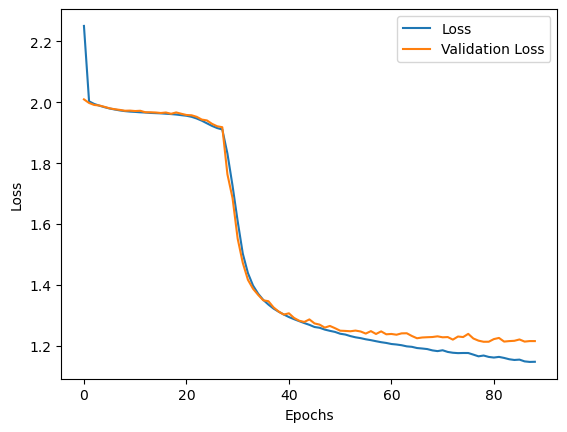

In [8]:
plot_model_training(history)

### Visualizing the Model's Predictions

2022-11-28 20:42:35.670311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 236 of 1000
2022-11-28 20:42:45.683000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 454 of 1000
2022-11-28 20:42:47.816527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1/1 [==============================] - 0s 61ms/step


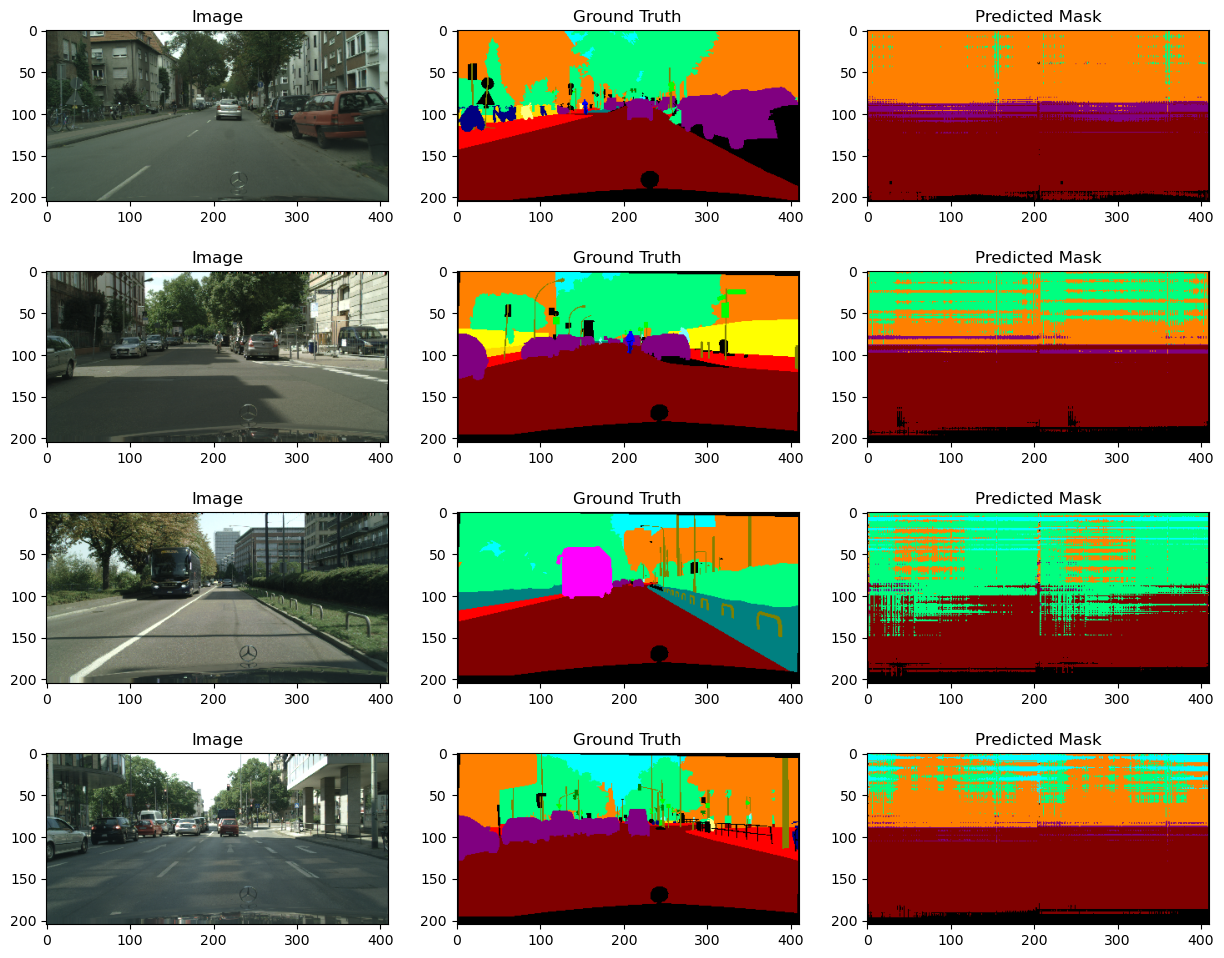

In [9]:
# Optionally load the model, get predictions and show them
use_saved_model = False

if use_saved_model:
    model = tf.keras.models.load_model('ViT')

examples_to_show = 4 # can't be greater than the batch size
show_examples(model, val_ds, examples_to_show)

The model is just starting to get the ideas of the scenes, but has very imprecise labelling. The only indication that it is starting to get the idea of the scenes is the prescence of more or less of the most common classes, and they generally aren't localized very well. This is despite various runs with some slightly different parameters (number of encoder blocks, etc.). This is likely due to the architecture being very complicated and the multihead attention mechanism allowing perhaps too much flexibility and making training harder. This model architecture is also meant to be used with a pre-trained ViT, which we aren't doing, which is making our training task significantly more difficult. The paper also talks about using a ViT pre-trained with multi-modal data, which is out of my computational reach.

All of this goes to show that despite all of the (justifiable) hype around transformers, for computer vision projects with limited computational resources and data, CNNs may still reign supreme.

### Saving the Model

In [10]:
model.save('ViT')

INFO:tensorflow:Assets written to: ViT/assets


INFO:tensorflow:Assets written to: ViT/assets
